In [36]:
# %run common_imports.py
import seaborn as sns
%matplotlib qt
%config InlineBackend.figure_format = 'retina'
sns.set_context("talk")

%reload_ext autoreload
%autoreload 2
pd.options.display.max_rows = 600
pd.set_option('display.float_format', lambda x: '%.9f' % x)

dj.config['display.limit'] = 10**3  

os.environ["SPYGLASS_USE_TRANSACTIONS"] = "1"  
os.environ['KACHERY_API_KEY'] = "RhysjLwgmBAt2ObCyXXaDnqAv2kTdYRa"

import sys
import tuning_analysis.sorting_multiprocessing as smp
import spyglass.spikesorting.v1 as sgs
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.core as sc
import spyglass.position.v1 as sgp
import spyglass.linearization.v1 as sgpl

from spyglass.position import PositionOutput
from spyglass.spikesorting.analysis.v1.group import UnitSelectionParams
from spyglass.spikesorting.analysis.v1.group import SortedSpikesGroup
from tuning_analysis.trial_extraction import *
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput
from tuning_analysis.spike_analysis import *
from pathlib import Path


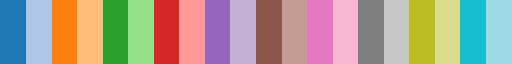

In [2]:
from cycler import cycler
cmap = 'tab20'
n_colors = 6
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0,1,n_colors)]
plt.rcParams["axes.prop_cycle"] = cycler(color = colors)
cmap

In [ ]:
# import matplotlib as mpl

# mpl.rcParams['font.family'] = 'Sans'/


In [ ]:
#select track graph
graph = sgpl.TrackGraph() & {"track_graph_name":"Wtrack_wilbur20210512"}

### Plot unit-wise spiking locations

#### Fetch spikes

In [5]:
sorter_keys = {
    "nwb_file_name": nwb_copy_file_name,
    "sorter": "mountainsort4",
    "curation_id": 2,
}

pfc_merge_ids = SpikeSortingOutput().get_restricted_merge_ids(sorter_keys, restrict_by_artifact = True)

keys = [{"merge_id": merge_id} for merge_id in pfc_merge_ids]
(SpikeSortingOutput.CurationV1 & keys)

[12:17:59][WARNING] Spyglass: V0 requires artifact restrict. Ignoring "restrict_by_artifact" flag.


merge_id,sorting_id,curation_id
047f4da5-c1d4-ca9e-f923-cdb63c0d04e7,d14d9669-4f3e-47c8-bed9-e0cc90be7a71,2
0a29f32c-7036-e6bb-fd45-dc7ac35137fe,45539c29-3436-4633-b63d-f499fe8e4073,2
1a818a97-6f62-8d75-565f-7be81c6961c3,ee34cd1e-e742-4c73-bdae-9974c2b1d74a,2
3b2a05fa-9642-5ef4-58d7-1f8e9bf3e217,76904362-d49e-4883-98d1-442822ebb9a1,2
4db00acd-003c-de9a-b640-fb78fb276985,df857aaa-ccd8-4abf-82e2-e9b97706c162,2
6e499686-18c3-ef61-e344-d4e7d7c5e773,bae249c1-f797-4e38-83ee-a21f51684a20,2
70ca787c-23b6-feb6-84af-6e3ba338fdf3,1dd1e911-c185-4488-b607-83502ac5225f,2
d4644925-b88e-850f-36a2-291d1e1b99f7,48a2c037-f872-4a63-9ccb-1bd14cb727e4,2
e7eb99a4-da0e-a1ca-3be6-36e6037f9275,6868b312-14db-473b-ae34-ce1bd193055d,2
e9df24a9-9413-0623-2987-3064c50394ed,0c0d6f10-5af6-4add-beac-67f101ecb017,2


In [6]:
# get spikes from a specific group
group_key = {
    "nwb_file_name": nwb_copy_file_name,
    "sorted_spikes_group_name": "left mPFC",
}

SortedSpikesGroup().Units & group_key
group_key = (SortedSpikesGroup & group_key).fetch1("KEY")

l_mpfc_spikes = SortedSpikesGroup().fetch_spike_data(group_key)


#### Fetch position

In [ ]:
epoch = 2
dlc_centroid_params_name = "four_paw_centroid"
pos_key = {
    "nwb_file_name": nwb_copy_file_name,
    "epoch": f"{epoch}", 
    "dlc_model_params_name": "WtrackSep5",
    "dlc_centroid_params_name": dlc_centroid_params_name  
}

merge_id = (PositionOutput.DLCPosV1() & pos_key).fetch1("merge_id")

#### Plot

In [8]:
centroid_position = (PositionOutput() & {"merge_id": merge_id}).fetch1_dataframe()

In [107]:
# Single unit firing across all positions
unit = 4
spike_times = l_mpfc_spikes[unit]
spike_times = spike_times
spike_times = pd.Series([spike_time if spike_time < centroid_position.index[-1] else np.nan for spike_time in spike_times]).dropna().to_list()
spike_positions = np.searchsorted(centroid_position.index.tolist(), spike_times)
fig,ax = plt.subplots(layout = "tight")
ax.scatter(centroid_position.position_x, centroid_position.position_y, s = 4, color = 'k', alpha = 0.03)
ax.scatter(centroid_position.position_x.iloc[spike_positions], centroid_position.position_y.iloc[spike_positions], color = "#1188d8", s = 4, label = "spikes")
plt.legend();

### Extract trials

In [ ]:
# generate all poisition data
epoch2_centroid_df, epoch2_linear_df = get_centroid_and_linear_position(epoch=2,)
epoch4_centroid_df, epoch4_linear_df = get_centroid_and_linear_position(epoch=4, )
epoch6_centroid_df, epoch6_linear_df = get_centroid_and_linear_position(epoch=6,)
epoch8_centroid_df, epoch8_linear_df = get_centroid_and_linear_position(epoch=8,)

#get lick evenets and trial events
lick_events_df = prepare_DIO_data(session_restriction=session_restrict, lick_event_threshold=2)
trials_df = prepare_trial_data(lick_events_df)
# merge position information with all trials
target = pd.concat([epoch2_centroid_df, epoch2_linear_df], axis = 1)
e2_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch4_centroid_df, epoch4_linear_df], axis = 1)
e4_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch6_centroid_df, epoch6_linear_df], axis = 1)
e6_trialized_position = merge_trial_df_with_target(target, trials_df)

target = pd.concat([epoch8_centroid_df, epoch8_linear_df], axis = 1)
e8_trialized_position = merge_trial_df_with_target(target, trials_df)


trialized_position = pd.concat([e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position], axis = 0)

maximum_trial_number_epoch_2 = e2_trialized_position["trial_number"].max()
maximum_trial_number_epoch_4 = e4_trialized_position["trial_number"].max()
maximum_trial_number_epoch_6 = e6_trialized_position["trial_number"].max()
maximum_trial_number_epoch_8 = e8_trialized_position["trial_number"].max()

trial_number_is_in_epoch_2 = (
    trialized_position["trial_number"] <= maximum_trial_number_epoch_2
)

trial_number_is_in_epoch_4 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_2)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_4)
)

trial_number_is_in_epoch_6 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_4)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_6)
)

trial_number_is_in_epoch_8 = (
    (trialized_position["trial_number"] > maximum_trial_number_epoch_6)
    & (trialized_position["trial_number"] <= maximum_trial_number_epoch_8)
)

trialized_position["epoch"] = np.select(
    condlist=[
        trial_number_is_in_epoch_2,
        trial_number_is_in_epoch_4,
        trial_number_is_in_epoch_6,
        trial_number_is_in_epoch_8,
    ],
    choicelist=[2, 4, 6, 8],
    default=np.nan,
)

rows_with_unassigned_epoch = trialized_position["epoch"].isna()
print(
    "error: ",
    trialized_position.loc[rows_with_unassigned_epoch, "trial_number"].unique(),
)

trialized_position

In [ ]:
# save position data
# out_dir = Path("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/") 
# out_dir.mkdir(parents=True, exist_ok=True)

# dataframes = [e2_trialized_position, e4_trialized_position, e6_trialized_position, e8_trialized_position, trialized_position]
# names = ["e2_trialized_position", "e4_trialized_position", "e6_trialized_position", "e8_trialized_position", "trialized_position"]

# for name, df in zip(names, dataframes):
#     df.to_csv(out_dir / f"{name}.csv", index=True)

In [ ]:
#read from csv
e2_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e2_trialized_position.csv", index_col = "time")
e4_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e4_trialized_position.csv", index_col = "time")
e6_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e6_trialized_position.csv", index_col = "time")
e8_trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/e8_trialized_position.csv", index_col = "time")
trialized_position = pd.read_csv("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/position/trialized_position.csv", index_col = "time")

In [26]:
trialized_position.head(2)

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed,linear_position,track_segment_id,projected_x_position,...,trial_duration (s),trial_label,trial_type,"trial_direction (previous, current, next)",left/right,speed_norm,trial_progress,trial_progress_distance,zone,epoch
time,,,,,,,,,,,,,,,,,,,,,
1620843475.612429380,83.000000000,130.841658279,64.731790850,-0.053658240,6.960407628,-0.472843676,6.976450064,316.186089589,2,130.840792016,...,31.147236824,error,NaN,"('middle', 'left')",NaN,0.061862556,0.000412091,0.000000000,reward,2.000000000
1620843475.627006292,84.000000000,130.978969045,64.705678785,-0.042659516,6.028157129,-0.518424175,6.050408415,316.323341727,2,130.978043812,...,31.147236824,error,NaN,"('middle', 'left')",NaN,0.053651030,0.000880091,0.000199549,reward,2.000000000


In [ ]:
# Plot trajectory for a single trial
trial = 12

t_start = trials_df.loc[trials_df["trial_number"] == trial, "trial_start"].iloc[0]
t_end = trials_df.loc[trials_df["trial_number"] == trial, "trial_end"].iloc[0]

# build boolean mask and select rows between the timestamps
mask = (l_centroid_df.index > t_start) & (l_centroid_df.index < t_end)
fig, ax = plt.subplots(layout = 'tight')
plot_background_position(l_centroid_df, ax)
l_centroid_df.loc[mask].plot.scatter(x = "position_x", y = "position_y", s = 8, ax = ax, c = l_centroid_df.loc[mask].index, cmap = "Blues")

In [39]:
#plot various phases of a task
trial = 10


mask_reward = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "reward")
mask_run = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "run")
mask_turn = ( trialized_position["trial_number"] == trial) & ( trialized_position["zone"] == "turn")

fig, ax = plt.subplots(figsize = (15, 15), layout = "tight")
plot_background_position( trialized_position.iloc[::20], ax)
# graph.plot_track_graph()
s = 40
trialized_position[mask_reward].plot.scatter(x = "position_x", y = "position_y", ax = ax,s = s )
trialized_position[mask_turn].plot.scatter(x = "position_x", y = "position_y", ax = ax, s=s)
trialized_position[mask_run].plot.scatter(x = "position_x", y = "position_y", ax = ax, s=s);

### Behavior

In [168]:
#number of trials per epoch

In [178]:
print("num trials in epoch 2: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==2]["trial_number"]))))
print("num trials in epoch 4: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==4]["trial_number"]))))
print("num trials in epoch 6: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==6]["trial_number"]))))
print("num trials in epoch 8: ", (len(pd.unique(trialized_position[trialized_position["epoch"]==8]["trial_number"]))))

num trials in epoch 2:  50
num trials in epoch 4:  56
num trials in epoch 6:  59
num trials in epoch 8:  56


In [181]:
#Incorrect trial numbers
print(pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"]))
print(len(pd.unique(trialized_position[trialized_position["trial_label"]=="error"]["trial_number"])))

[  1   2   3   4  53  54  56  64  98 104 122 124 126 136 154 156 168 170
 173 186 204]
21


In [8]:
#plot single trial trajectory and speed 
trial = 106
mask = (trialized_position["trial_number"]==trial) &( trialized_position["zone"]=="run")
timestamps = trialized_position[mask].index - trialized_position[mask].index.tolist()[0]
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(1, 2, layout = "tight", figsize = (20, 10))
    plot_background_position(trialized_position, ax[0], background_color="white")
    trialized_position[mask].plot.scatter(x = "position_x", y = "position_y", ax = ax[0], c = "speed", s = 20, vmin = 0, vmax = 80)
    ax[1].plot(timestamps, trialized_position[mask]["speed"])

### Spingle unit spikes/behavior tuning

#### Fetch spikes

In [20]:
def fetch_single_epoch_spikes(nwb_file_name: str,
                              sorted_spikes_group_nane: str):
    group_key = {
        "nwb_file_name": nwb_file_name,
        "sorted_spikes_group_name": sorted_spikes_group_nane
    }
    
    SortedSpikesGroup.Units & group_key
    
    group_key = (SortedSpikesGroup & group_key).fetch1("KEY")
    return SortedSpikesGroup().fetch_spike_data(group_key)

In [63]:
mpfc_spikes = fetch_single_epoch_spikes(nwb_file_name=nwb_copy_file_name, sorted_spikes_group_nane="mPFC")

In [ ]:
# save as .npz
# out_dir = Path("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/final_spikes/")
# out_dir.mkdir(parents=True, exist_ok=True)

# np.savez_compressed(out_dir / "mfpc_spikes.npz", *mpfc_spikes)


In [27]:
#load saved spikes
data = np.load("/media/labuser/NA_1_2025/spyglass/wilbur/analysis/final_spikes/mfpc_spikes.npz", allow_pickle=True)
mpfc_spikes = [data[f"arr_{i}"] for i in range(len(data.files))]


#### Speed tuning

##### Compute tuning

In [ ]:
#rest vs run single unit comparison
mean_fr_df = rest_vs_run_firing_rates(mpfc_spikes, trialized_position[(trialized_position["track_segment_id"]==2)]
                                      , speed_threshold=5, segment_threshold=3)
plot_rest_vs_run_fr(mean_fr_df)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

In [59]:
#compute tuning
df = trialized_position.copy()
spikes_list = mpfc_spikes.copy()

zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]
epochs = [2,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones)) & \
                    df["epoch"].isin(epochs)


speed_tuning, speed_centers, lo, hi, slope_boot, curv_boot = compute_tuning_bootstrap_trials(
    df,
    spikes_list=spikes_list,
    mask=mask,
    column ="speed",
    binning="sliding",
    window_width=20,
    window_step=2,
    tuner_min=0,
    tuner_max=120,
    n_boot=500,
    random_state=0,
    peak_normalize = True
)




shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curv_boot,
    ci=0.95,
    min_valid_boot=200,   
)
unit_shapes = pd.Series(shape_by_unit)
speed_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
speed_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
speed_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
speed_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
speed_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



In [ ]:
#plot tuning grid
plot_tuning_grid_bootstrap(
    speed_tuning, lo, hi, speed_centers,
    column="speed",
    n_units=80,
    s=3,
    color="tab:blue",
    peak_normalize = True,
    linewidth = 2,
    indices = None,
    
)

In [60]:
def _counts_in_windows(values: np.ndarray, left_edges: np.ndarray, right_edges: np.ndarray) -> np.ndarray:
    """
    Count how many `values` fall in each half-open interval [left, right).

    This is used for sliding-window ("continuous") binning where windows can overlap.
    """
    left_edges = np.asarray(left_edges, dtype=float)
    right_edges = np.asarray(right_edges, dtype=float)
    if left_edges.shape != right_edges.shape:
        raise ValueError("left_edges and right_edges must have the same shape")

    values = np.asarray(values, dtype=float)
    values = values[np.isfinite(values)]
    if values.size == 0:
        return np.zeros(left_edges.shape, dtype=np.int64)

    values_sorted = np.sort(values)
    li = np.searchsorted(values_sorted, left_edges, side="left")
    ri = np.searchsorted(values_sorted, right_edges, side="left")
    return (ri - li).astype(np.int64)


def _bootstrap_rates_boot_trials_1d(
    position_df: pd.DataFrame,
    *,
    column: str,
    spikes_list: list,
    mask: np.ndarray,
    trial_column: str = "trial_number",
    n_boot: int = 500,
    ci: float = 0.95,
    random_state: int = 0,
    # binning params (match your compute_tuning_bootstrap_trials call)
    n_bins: int = 6,
    tuner_bins: np.ndarray = None,
    binning: str = "edges",
    window_width: float = None,
    window_step: float = None,
    tuner_min: float = None,
    tuner_max: float = None,
    # options
    unit_ids=None,
    peak_normalize: bool = False,
):
    """
    Reconstruct per-unit bootstrap replicate tuning curves rates_boot (n_boot, n_bins)
    using the same trial-resampling logic as compute_tuning_bootstrap_trials(...).

    Returns
    -------
    centers : (n_bins,) array
    rates_boot_by_unit : dict[unit_id] -> (n_boot, n_bins) float array
    meta : dict with trial_ids, occupancy_time_trials, etc. (useful for debugging)
    """
    if trial_column not in position_df.columns:
        raise KeyError(f"position_df missing {trial_column=}")
    if len(position_df.index) < 2:
        raise ValueError("position_df must have >=2 timestamp samples")
    if not pd.Index(position_df.index).is_monotonic_increasing:
        raise ValueError("position_df.index must be sorted/monotonic increasing")

    timestamps = position_df.index.to_numpy()
    x_raw = position_df[column].to_numpy()
    trial_ids_raw = position_df[trial_column].to_numpy()

    mask = np.asarray(mask, dtype=bool)
    if mask.shape[0] != x_raw.shape[0]:
        raise ValueError("mask length must match position_df length")

    # match compute_tuning_bootstrap_trials: require valid trial id under mask
    trial_ok = ~pd.isna(trial_ids_raw)
    mask = mask & trial_ok

    dt = float(np.median(np.diff(timestamps)))
    if not np.isfinite(dt) or dt <= 0:
        raise ValueError("Bad dt from timestamps")

    x_masked = x_raw[mask]
    if x_masked.size == 0:
        raise ValueError("Mask leaves zero samples")

    # --- build bins/windows exactly like compute_tuning_bootstrap_trials ---
    mode = _validate_binning_mode(binning)

    if mode == "edges":
        if tuner_bins is None:
            max_tuner = float(np.nanmax(x_masked))
            tuner_bins = np.linspace(0, max_tuner, int(n_bins) + 1)
        else:
            tuner_bins = np.asarray(tuner_bins, dtype=float)
            if tuner_bins.ndim != 1 or len(tuner_bins) != int(n_bins) + 1:
                raise ValueError("tuner_bins must be 1D length n_bins+1")
            if not np.all(np.diff(tuner_bins) > 0):
                raise ValueError("tuner_bins must be strictly increasing")
        centers = (tuner_bins[:-1] + tuner_bins[1:]) / 2.0
        left_edges = None
        right_edges = None
        n_bins_eff = int(n_bins)
    else:
        bin_spec = _prepare_tuner_binning(
            x_masked,
            n_bins=int(n_bins),
            tuner_bins=None,
            binning="sliding",
            window_width=window_width,
            window_step=window_step,
            tuner_min=tuner_min,
            tuner_max=tuner_max,
        )
        centers = np.asarray(bin_spec["centers"], dtype=float)
        left_edges = np.asarray(bin_spec["left"], dtype=float)
        right_edges = np.asarray(bin_spec["right"], dtype=float)
        n_bins_eff = int(centers.size)

    # --- trial list (match compute_tuning_bootstrap_trials) ---
    trial_ids_masked = np.asarray(trial_ids_raw[mask]).astype(int)
    trial_ids = np.unique(trial_ids_masked)
    trial_ids = np.sort(trial_ids)
    n_trials = int(trial_ids.size)
    if n_trials < 2:
        raise ValueError(f"Need >=2 trials for bootstrap; found {n_trials}")

    # --- occupancy per (trial, bin) from masked samples ---
    if mode == "edges":
        trial_idx_per_sample = np.searchsorted(trial_ids, trial_ids_masked)

        x_masked_vals = np.asarray(x_masked, dtype=float)
        finite = np.isfinite(x_masked_vals)
        bin_idx = np.searchsorted(tuner_bins, x_masked_vals, side="right") - 1
        bin_idx[bin_idx == n_bins_eff] = n_bins_eff - 1
        valid_bin = finite & (bin_idx >= 0) & (bin_idx < n_bins_eff)

        flat_occ = np.bincount(
            trial_idx_per_sample[valid_bin] * n_bins_eff + bin_idx[valid_bin],
            minlength=n_trials * n_bins_eff,
        )
        occupancy_counts_trials = flat_occ.reshape(n_trials, n_bins_eff)
    else:
        # sliding: count samples per window within each trial
        x_masked_vals = np.asarray(x_masked, dtype=float)
        t_masked_vals = np.asarray(trial_ids_masked, dtype=int)

        finite = np.isfinite(x_masked_vals)
        x_masked_vals = x_masked_vals[finite]
        t_masked_vals = t_masked_vals[finite]

        trial_idx = np.searchsorted(trial_ids, t_masked_vals)
        order = np.argsort(trial_idx, kind="mergesort")
        trial_idx_sorted = trial_idx[order]
        x_sorted_by_trial = x_masked_vals[order]

        occupancy_counts_trials = np.zeros((n_trials, n_bins_eff), dtype=np.int64)
        for t in range(n_trials):
            s = np.searchsorted(trial_idx_sorted, t, side="left")
            e = np.searchsorted(trial_idx_sorted, t, side="right")
            if e <= s:
                continue
            occupancy_counts_trials[t, :] = _counts_in_windows(x_sorted_by_trial[s:e], left_edges, right_edges)

    occupancy_time_trials = occupancy_counts_trials * dt  # seconds

    # --- bootstrap weights (trial resampling) ---
    rng = np.random.default_rng(random_state)
    weights = rng.multinomial(n_trials, np.ones(n_trials) / n_trials, size=int(n_boot)).astype(float)

    occupancy_time_boot = weights @ occupancy_time_trials  # (n_boot, n_bins)

    # --- per-unit spike counts per (trial, bin) ---
    # IMPORTANT: this maps spikes -> position sample index -> (trial, x)
    # like compute_tuning_bootstrap_trials does around tuning_analysis/spike_analysis.py:2591
    timestamps_arr = np.asarray(timestamps)
    x_arr = np.asarray(x_raw, dtype=float)
    mask_arr = np.asarray(mask, dtype=bool)

    def _spike_counts_trials_for_unit(spike_times: np.ndarray) -> np.ndarray:
        spike_times = np.asarray(spike_times)

        t0, t1 = timestamps_arr[0], timestamps_arr[-1]
        in_window = (spike_times >= t0) & (spike_times <= t1)
        spike_times_win = spike_times[in_window]
        if spike_times_win.size == 0:
            return np.zeros((n_trials, n_bins_eff), dtype=np.int64)

        spike_pos_idx = np.searchsorted(timestamps_arr, spike_times_win, side="right") - 1
        spike_pos_idx = np.clip(spike_pos_idx, 0, len(timestamps_arr) - 1)

        keep = mask_arr[spike_pos_idx]
        if not np.any(keep):
            return np.zeros((n_trials, n_bins_eff), dtype=np.int64)
        spike_pos_idx = spike_pos_idx[keep]

        spike_trials = trial_ids_raw[spike_pos_idx]
        spike_x = x_arr[spike_pos_idx]

        ok = (~pd.isna(spike_trials)) & np.isfinite(spike_x)
        if not np.any(ok):
            return np.zeros((n_trials, n_bins_eff), dtype=np.int64)

        spike_trials = spike_trials[ok].astype(int)
        spike_x = spike_x[ok].astype(float)

        spike_trial_idx = np.searchsorted(trial_ids, spike_trials)
        valid_trial = (
            (spike_trial_idx >= 0)
            & (spike_trial_idx < n_trials)
            & (trial_ids[spike_trial_idx] == spike_trials)
        )
        if not np.any(valid_trial):
            return np.zeros((n_trials, n_bins_eff), dtype=np.int64)

        spike_trial_idx = spike_trial_idx[valid_trial]
        spike_x = spike_x[valid_trial]

        if mode == "edges":
            spike_bin_idx = np.searchsorted(tuner_bins, spike_x, side="right") - 1
            spike_bin_idx[spike_bin_idx == n_bins_eff] = n_bins_eff - 1
            valid = (spike_bin_idx >= 0) & (spike_bin_idx < n_bins_eff)
            if not np.any(valid):
                return np.zeros((n_trials, n_bins_eff), dtype=np.int64)

            flat = np.bincount(
                spike_trial_idx[valid] * n_bins_eff + spike_bin_idx[valid],
                minlength=n_trials * n_bins_eff,
            )
            return flat.reshape(n_trials, n_bins_eff)

        # sliding: count spikes per window within each trial
        out = np.zeros((n_trials, n_bins_eff), dtype=np.int64)
        order = np.argsort(spike_trial_idx, kind="mergesort")
        trial_idx_sorted = spike_trial_idx[order]
        x_sorted_by_trial = spike_x[order]
        for t in range(n_trials):
            s = np.searchsorted(trial_idx_sorted, t, side="left")
            e = np.searchsorted(trial_idx_sorted, t, side="right")
            if e <= s:
                continue
            out[t, :] = _counts_in_windows(x_sorted_by_trial[s:e], left_edges, right_edges)
        return out

    if unit_ids is None:
        unit_ids = list(range(len(spikes_list)))
    unit_ids = list(unit_ids)

    # --- CI quantiles (for optional peak-normalization of boot curves) ---
    alpha = 1.0 - float(ci)
    lo_q = 100.0 * (alpha / 2.0)
    hi_q = 100.0 * (1.0 - alpha / 2.0)

    rates_boot_by_unit = {}
    for u in unit_ids:
        counts_trials = _spike_counts_trials_for_unit(spikes_list[u])
        spike_counts_boot = weights @ counts_trials  # (n_boot, n_bins)
        with np.errstate(divide="ignore", invalid="ignore"):
            rates_boot = spike_counts_boot / occupancy_time_boot

        # match compute_tuning_bootstrap_trials thresholding
        rates_boot[occupancy_time_boot <= MIN_OCCUPANCY] = np.nan

        if peak_normalize:
            # mirror your module’s peak-normalize definition: scale = max_x upper_CI(x)
            hi = np.nanpercentile(rates_boot, hi_q, axis=0)
            scale = float(np.nanmax(hi)) if np.any(np.isfinite(hi)) else np.nan
            if np.isfinite(scale) and scale > 0:
                rates_boot = rates_boot / scale

        rates_boot_by_unit[u] = rates_boot

    meta = dict(
        trial_ids=trial_ids,
        centers=centers,
        occupancy_time_trials=occupancy_time_trials,
        occupancy_time_boot=occupancy_time_boot,
        weights=weights,
        dt=dt,
        mode=mode,
    )
    return centers, rates_boot_by_unit, meta


In [130]:
def _moving_average_1d(y: np.ndarray, win: int) -> np.ndarray:
    y = np.asarray(y, dtype=float)
    if win is None or win <= 1:
        return y
    win = int(win)
    if win % 2 == 0:
        win += 1  # force odd so output length matches input
    pad = win // 2
    ypad = np.pad(y, (pad, pad), mode="edge")
    kernel = np.ones(win, dtype=float) / win
    out = np.convolve(ypad, kernel, mode="valid")
    if out.shape[0] != y.shape[0]:
        raise RuntimeError(f"moving average length mismatch: {out.shape[0]} vs {y.shape[0]}")
    return out



def _robust_sigma_y_from_boot(rates_boot: np.ndarray) -> float:
    """
    rates_boot: (n_boot, n_bins)
    Estimate typical per-bin variability, then summarize across bins.
    """
    rb = np.asarray(rates_boot, dtype=float)
    if rb.ndim != 2:
        raise ValueError("rates_boot must be 2D (n_boot, n_bins)")
    # per-bin IQR across replicates
    q75 = np.nanpercentile(rb, 75, axis=0)
    q25 = np.nanpercentile(rb, 25, axis=0)
    iqr = q75 - q25
    # normal approx: sigma ~= IQR / 1.349
    sigma_bins = iqr / 1.349
    sigma = float(np.nanmedian(sigma_bins)) if np.any(np.isfinite(sigma_bins)) else np.nan
    return sigma

def classify_curve_deriv_extrema(
    x: np.ndarray,
    y: np.ndarray,
    *,
    sigma_y: float,
    smooth_win: int = 3,
    edge_bins: int = 2,
    monotone_frac: float = 0.8,  # kept for API compatibility (unused)
    flat_factor: float = 1.0,
    prom_factor: float = 2.0,
    prom_factor_local: float = 2.0,
    dx_factor: float = 1.0,
    min_valid_bins: int = 5,
):
    """
    Derivative/extrema-based shape classifier with bootstrap-scale thresholds.

    Labels: flat, increasing, decreasing, bell, U, complex, unusable

    Design goals:
    - "flat" if overall modulation is small vs bootstrap noise scale
    - "bell"/"U" if there is a strong *global* interior max/min (two-sided vs endpoints)
      AND curve is not multimodal (veto based on significant local extrema)
    - "increasing"/"decreasing" should include "trend then plateau" curves:
      allow most derivatives to be "flat" as long as net_change is strongly signed
    - "complex" otherwise
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    ok = np.isfinite(x) & np.isfinite(y)
    if np.sum(ok) < min_valid_bins:
        return "unusable", {"n_ok": int(np.sum(ok))}

    xv = x[ok]
    yv = y[ok]

    order = np.argsort(xv)
    xv = xv[order]
    yv = yv[order]

    y_s = _moving_average_1d(yv, smooth_win)

    n = y_s.size
    eb = int(edge_bins)
    eb = max(1, min(eb, max(1, n // 4)))

    # ---- flat gate ----
    y_range = float(np.nanmax(y_s) - np.nanmin(y_s))
    flat_thr = float(flat_factor) * float(sigma_y) if np.isfinite(sigma_y) else np.nan
    if np.isfinite(flat_thr) and y_range < flat_thr:
        return "flat", {"y_range": y_range, "flat_thr": flat_thr}

    # ---- derivative threshold ----
    dx = np.diff(xv)
    dx_med = float(np.median(dx)) if dx.size else np.nan
    if not np.isfinite(dx_med) or dx_med <= 0 or (not np.isfinite(sigma_y)) or sigma_y <= 0:
        eps_dx = 0.0
    else:
        eps_dx = float(dx_factor) * float(sigma_y) / dx_med

    dy = np.gradient(y_s, xv)

    # ---- candidate extrema via derivative sign changes ----
    def _fill_zeros_with_neighbors(sign_arr: np.ndarray) -> np.ndarray:
        s = sign_arr.copy()
        last = 0
        for i in range(s.size):
            if s[i] == 0:
                s[i] = last
            else:
                last = s[i]
        if s.size and s[0] == 0:
            first_nz = 0
            for v in s:
                if v != 0:
                    first_nz = v
                    break
            s[s == 0] = first_nz
        return s

    def _segments(sign_arr: np.ndarray):
        segs = []
        start = 0
        cur = int(sign_arr[0])
        for i in range(1, sign_arr.size):
            if int(sign_arr[i]) != cur:
                segs.append((start, i - 1, cur))
                start = i
                cur = int(sign_arr[i])
        segs.append((start, sign_arr.size - 1, cur))
        return segs

    def _candidate_extrema_indices(y_s: np.ndarray, dy: np.ndarray, eps_dx: float):
        s = np.zeros_like(dy, dtype=int)
        s[dy > eps_dx] = 1
        s[dy < -eps_dx] = -1
        if not np.any(s != 0):
            return [], []

        s_f = _fill_zeros_with_neighbors(s)
        segs = _segments(s_f)

        cand_max = []
        cand_min = []
        for (a0, b0, s0), (a1, b1, s1) in zip(segs[:-1], segs[1:]):
            if s0 == 1 and s1 == -1:
                lo = max(0, a0)
                hi = min(n - 1, b1 + 1)
                idx = int(lo + np.nanargmax(y_s[lo : hi + 1]))
                cand_max.append(idx)
            elif s0 == -1 and s1 == 1:
                lo = max(0, a0)
                hi = min(n - 1, b1 + 1)
                idx = int(lo + np.nanargmin(y_s[lo : hi + 1]))
                cand_min.append(idx)

        return sorted(set(cand_max)), sorted(set(cand_min))

    def _significant_extrema(y_s: np.ndarray):
        cand_max, cand_min = _candidate_extrema_indices(y_s, dy, eps_dx)

        # only interior candidates
        cand_max = sorted([i for i in cand_max if (i >= eb) and (i <= n - eb - 1)])
        cand_min = sorted([i for i in cand_min if (i >= eb) and (i <= n - eb - 1)])

        prom_thr_local = float(prom_factor_local) * float(sigma_y) if np.isfinite(sigma_y) else np.nan
        if (not np.isfinite(prom_thr_local)) or prom_thr_local <= 0:
            return [], [], prom_thr_local

        def _nearest_left(sorted_list, idx):
            out = None
            for v in sorted_list:
                if v < idx:
                    out = v
                else:
                    break
            return out

        def _nearest_right(sorted_list, idx):
            for v in sorted_list:
                if v > idx:
                    return v
            return None

        sig_max = []
        sig_min = []

        # Peak significant only if bracketed by minima on both sides
        for p in cand_max:
            lmin = _nearest_left(cand_min, p)
            rmin = _nearest_right(cand_min, p)
            if lmin is None or rmin is None:
                continue
            baseline = max(float(y_s[lmin]), float(y_s[rmin]))
            prom = float(y_s[p]) - baseline
            if prom > prom_thr_local:
                sig_max.append(p)

        # Trough significant only if bracketed by maxima on both sides
        for t in cand_min:
            lmax = _nearest_left(cand_max, t)
            rmax = _nearest_right(cand_max, t)
            if lmax is None or rmax is None:
                continue
            baseline = min(float(y_s[lmax]), float(y_s[rmax]))
            prom = baseline - float(y_s[t])
            if prom > prom_thr_local:
                sig_min.append(t)

        return sig_max, sig_min, prom_thr_local

    sig_max, sig_min, prom_thr_local = _significant_extrema(y_s)

    # ---- multi-extrema veto (only LARGE extrema) ----
    if (len(sig_max) > 1) or (len(sig_min) > 1):
        return "complex", {
            "reason": "multi_extrema_veto_significant",
            "sig_max": sig_max,
            "sig_min": sig_min,
            "prom_thr_local": prom_thr_local,
            "eps_dx": eps_dx,
        }

    # ---- global bell/U test (two-sided vs endpoints) ----
    y_left = float(np.median(y_s[:eb]))
    y_right = float(np.median(y_s[-eb:]))

    i_max = int(np.nanargmax(y_s))
    i_min = int(np.nanargmin(y_s))

    interior_max = (i_max >= eb) and (i_max <= n - eb - 1)
    interior_min = (i_min >= eb) and (i_min <= n - eb - 1)

    prom_thr = float(prom_factor) * float(sigma_y) if np.isfinite(sigma_y) else np.nan

    peak = float(y_s[i_max])
    trough = float(y_s[i_min])

    prom_max_two_sided = float(min(peak - y_left, peak - y_right))
    prom_min_two_sided = float(min(y_left - trough, y_right - trough))

    bell_ok = interior_max and np.isfinite(prom_thr) and (prom_max_two_sided > prom_thr)
    u_ok = interior_min and np.isfinite(prom_thr) and (prom_min_two_sided > prom_thr)

    # If there is any significant opposite-type extremum, this isn't a clean bell/U
    # (e.g. if calling bell but we also found a significant trough, treat as complex)
    if bell_ok and (len(sig_min) > 0):
        bell_ok = False
    if u_ok and (len(sig_max) > 0):
        u_ok = False

    if bell_ok and (not u_ok):
        return "bell", {
            "i_max": i_max,
            "prom_thr": prom_thr,
            "prom_max_two_sided": prom_max_two_sided,
            "sig_max": sig_max,
            "sig_min": sig_min,
        }
    if u_ok and (not bell_ok):
        return "U", {
            "i_min": i_min,
            "prom_thr": prom_thr,
            "prom_min_two_sided": prom_min_two_sided,
            "sig_max": sig_max,
            "sig_min": sig_min,
        }
    if bell_ok and u_ok:
        return "complex", {"bell_ok": True, "u_ok": True}

    # ---- monotone classification (plateau-friendly) ----
    frac_pos = float(np.mean(dy > eps_dx)) if dy.size else 0.0
    frac_neg = float(np.mean(dy < -eps_dx)) if dy.size else 0.0
    frac_flat = float(np.mean(np.abs(dy) <= eps_dx)) if dy.size else 0.0

    # robust net change
    net_change = float(np.median(y_s[-eb:]) - np.median(y_s[:eb]))
    net_thr = float(flat_thr) if np.isfinite(flat_thr) else 0.0

    # knobs (chosen to fix your unit 0 debug pattern)
    max_opposite_frac = 0.15

    # Route A (strongly monotone across curve)
    min_trend_frac_strong = 0.20

    # Route B (trend then plateau)
    min_trend_frac_weak = 0.05

    # Require stronger-than-flat net change for plateau route so flat units don't become inc/dec
    strong_net_k = 3.0
    strong_net_thr = strong_net_k * net_thr

    # decreasing
    if (frac_pos <= max_opposite_frac) and (
        ((frac_neg >= min_trend_frac_strong) and (net_change < -net_thr)) or
        ((frac_neg >= min_trend_frac_weak) and (net_change < -strong_net_thr)) or
        (net_change < -strong_net_thr)
    ):
        return "decreasing", {
            "frac_pos": frac_pos,
            "frac_neg": frac_neg,
            "frac_flat": frac_flat,
            "eps_dx": eps_dx,
            "net_change": net_change,
            "net_thr": net_thr,
            "strong_net_thr": strong_net_thr,
        }

    # increasing
    if (frac_neg <= max_opposite_frac) and (
        ((frac_pos >= min_trend_frac_strong) and (net_change > net_thr)) or
        ((frac_pos >= min_trend_frac_weak) and (net_change > strong_net_thr)) or
        (net_change > strong_net_thr)
    ):
        return "increasing", {
            "frac_pos": frac_pos,
            "frac_neg": frac_neg,
            "frac_flat": frac_flat,
            "eps_dx": eps_dx,
            "net_change": net_change,
            "net_thr": net_thr,
            "strong_net_thr": strong_net_thr,
        }

    return "complex", {
        "sig_max": sig_max,
        "sig_min": sig_min,
        "prom_thr_local": prom_thr_local,
        "frac_pos": frac_pos,
        "frac_neg": frac_neg,
        "frac_flat": frac_flat,
        "eps_dx": eps_dx,
        "net_change": net_change,
        "net_thr": net_thr,
        "strong_net_thr": strong_net_thr,
    }









def classify_unit_from_rates_boot(
    x: np.ndarray,
    rates_boot: np.ndarray,
    *,
    smooth_win: int = 3,
    edge_bins: int = 2,
    monotone_frac: float = 0.8,
    flat_factor: float = 1.5,
    prom_factor: float = 2.0,
    prom_factor_local: float = 2.0,
    dx_factor: float = 1.0,
    min_valid_bins: int = 5,
):
    rb = np.asarray(rates_boot, dtype=float)
    sigma_y = _robust_sigma_y_from_boot(rb)

    labels = []
    for r in range(rb.shape[0]):
        label, _dbg = classify_curve_deriv_extrema(
            x,
            rb[r, :],
            sigma_y=sigma_y,
            smooth_win=smooth_win,
            edge_bins=edge_bins,
            monotone_frac=monotone_frac,
            flat_factor=flat_factor,
            prom_factor=prom_factor,
            prom_factor_local=prom_factor_local,
            dx_factor=dx_factor,
            min_valid_bins=min_valid_bins,
        )
        if label != "unusable":
            labels.append(label)

    n_usable = len(labels)
    if n_usable == 0:
        return {"unusable": 1.0}, {"sigma_y": sigma_y, "n_usable": 0}

    probs = {k: labels.count(k) / n_usable for k in set(labels)}
    for k in ["increasing", "decreasing", "bell", "U", "flat", "complex"]:
        probs.setdefault(k, 0.0)

    summary = {"sigma_y": sigma_y, "n_usable": n_usable}
    return probs, summary


In [131]:
unit_ids_test = list(range(20))  
df = trialized_position.copy()
centers, rates_boot_by_unit, meta = _bootstrap_rates_boot_trials_1d(
    df,
    column="speed",
    spikes_list=spikes_list,
    mask=base_mask,
    trial_column="trial_number",
    n_boot=500,
    ci=0.95,
    random_state=0,
    binning="sliding",
    window_width=20,
    window_step=2,
    tuner_min=0,
    tuner_max=120,
    unit_ids=None,
    peak_normalize=True,  
)

probs_by_unit = {}
summary_by_unit = {}
for u, rb in rates_boot_by_unit.items():
    probs, summary = classify_unit_from_rates_boot(
        centers,
        rb,
        smooth_win=5,
        edge_bins=6,
        monotone_frac=0.8,
        flat_factor=1.0,
        prom_factor=2.0,
        prom_factor_local= 3.0,
        dx_factor=1.0,
        min_valid_bins=8,
    )
    probs_by_unit[u] = probs
    summary_by_unit[u] = summary

probs_df = pd.DataFrame.from_dict(probs_by_unit, orient="index")
summ_df = pd.DataFrame.from_dict(summary_by_unit, orient="index")
display(probs_df.join(summ_df).sort_values("complex", ascending=False).head(10))


,decreasing,increasing,bell,U,flat,complex,sigma_y,n_usable
111,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,1.000000000,0.000000000,500
262,0.002000000,0.132000000,0.146000000,0.056000000,0.000000000,0.664000000,0.125904433,500
75,0.022000000,0.094000000,0.258000000,0.016000000,0.000000000,0.610000000,0.092221799,500
235,0.232000000,0.004000000,0.134000000,0.038000000,0.000000000,0.592000000,0.069866652,500
250,0.012000000,0.006000000,0.058000000,0.400000000,0.000000000,0.524000000,0.073984144,500
107,0.006000000,0.022000000,0.450000000,0.012000000,0.000000000,0.510000000,0.139808747,500
211,0.226000000,0.000000000,0.268000000,0.010000000,0.000000000,0.496000000,0.082320561,500
188,0.002000000,0.112000000,0.224000000,0.174000000,0.000000000,0.488000000,0.079321653,500
113,0.078000000,0.000000000,0.088000000,0.364000000,0.000000000,0.470000000,0.036805676,500
99,0.000000000,0.134000000,0.392000000,0.034000000,0.000000000,0.440000000,0.105835169,500


In [132]:
p_thr = 0.8
bell_ids = probs_df.index[probs_df["bell"] >= p_thr].tolist()
u_ids = probs_df.index[probs_df["U"] >= p_thr].tolist()
inc_ids = probs_df.index[probs_df["increasing"] >= p_thr].tolist()
dec_ids = probs_df.index[probs_df["decreasing"] >= p_thr].tolist()
flat_ids = probs_df.index[probs_df["flat"] >= p_thr].tolist()
complex_ids = probs_df.index[probs_df["complex"] >= p_thr].tolist()

print("bell", len(bell_ids), "U", len(u_ids), "inc", len(inc_ids), "dec", len(dec_ids), "flat", len(flat_ids), "complex", len(complex_ids))


bell 53 U 32 inc 32 dec 55 flat 0 complex 1


In [129]:
u = 0  # unit id you care about
rb = rates_boot_by_unit[u]          # (n_boot, n_bins)
sigma_y = _robust_sigma_y_from_boot(rb)

for r in [0, 1, 2, 3, 4]:  # pick some reps
    label, dbg = classify_curve_deriv_extrema(
        centers,
        rb[r, :],
        sigma_y=sigma_y,
        smooth_win=5,
        edge_bins=6,
        flat_factor=1.5,
        prom_factor=2.0,
        prom_factor_local=2.0,
        dx_factor=1.0,
        min_valid_bins=8,
    )
    print(f"unit={u} rep={r} label={label}")
    print(dbg)
    print("-" * 80)


unit=0 rep=0 label=complex
{'sig_max': [], 'sig_min': [], 'prom_thr_local': 0.05176446801877383, 'frac_pos': 0.0, 'frac_neg': 0.19607843137254902, 'frac_flat': 0.803921568627451, 'eps_dx': 0.012941117004693458, 'net_change': -0.618043551684949, 'net_thr': 0.038823351014080375}
--------------------------------------------------------------------------------
unit=0 rep=1 label=complex
{'sig_max': [], 'sig_min': [], 'prom_thr_local': 0.05176446801877383, 'frac_pos': 0.0, 'frac_neg': 0.13725490196078433, 'frac_flat': 0.8627450980392157, 'eps_dx': 0.012941117004693458, 'net_change': -0.6051822686574454, 'net_thr': 0.038823351014080375}
--------------------------------------------------------------------------------
unit=0 rep=2 label=complex
{'sig_max': [], 'sig_min': [], 'prom_thr_local': 0.05176446801877383, 'frac_pos': 0.0, 'frac_neg': 0.1568627450980392, 'frac_flat': 0.8431372549019608, 'eps_dx': 0.012941117004693458, 'net_change': -0.6136022921438574, 'net_thr': 0.038823351014080375}
-

In [136]:
#plot tuning grid
plot_tuning_grid_bootstrap(
    speed_tuning, lo, hi, speed_centers,
    column="speed",
    n_units=-1,
    s=3,
    color="tab:blue",
    peak_normalize = True,
    linewidth = 2,
    indices = bell_ids,
    
)

In [49]:
#plot SINGLE UNIT tuning
unit_to_plot = 70

fig, ax = plt.subplots(1, 1, figsize=(8,4))
plot_unit_tuning_bootstrap(
    unit_to_plot,
    speed_tuning, speed_centers, lo, hi,
    ax=ax,
    color="tab:blue",
    s=3,
    linewidth=2,
    peak_normalize=True,   
    xlabel="speed",
)
plt.tight_layout()
plt.show()


NameError: name 'speed_tuning' is not defined

##### Stability within an epoch

###### Run for ONE epoch

In [33]:
# --- Early vs Late - for PLOTTING one unit
df = trialized_position.copy()
spikes_list = mpfc_spikes.copy()

trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1, 2, 3, 4]
zones = ["run"]

base_mask = (
    df["trial_type"].isin(trial_types)
    & df["track_segment_id"].isin(track_segment_ids)
    & df["zone"].isin(zones)
)

epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)
# e = epoch_vals[0]  
e = [2,4]


trials_e = np.sort(df.loc[base_mask & (df["epoch"].isin(e)), "trial_number"].dropna().unique())
M = len(trials_e)
half = M // 2
early_trials = trials_e[:half]
late_trials  = trials_e[half:]
print(f"epoch {e}: n_trials={M} (early={len(early_trials)}, late={len(late_trials)})")

mask_early = base_mask & (df["epoch"].isin(e)) & (df["trial_number"].isin(early_trials))
mask_late  = base_mask & (df["epoch"].isin(e)) & (df["trial_number"].isin(late_trials))


column = "speed"     
tuner_min = 10
tuner_max = 120
window_width = 20
window_step  = 2

common_kwargs = dict(
    spikes_list=spikes_list,
    column=column,
    binning="sliding",      
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
    peak_normalize=True,        
)

tun_early, centers, lo_early, hi_early, *_ = compute_tuning_bootstrap_trials(
    df, mask=mask_early, **common_kwargs
)
tun_late, centers2, lo_late, hi_late, *_ = compute_tuning_bootstrap_trials(
    df, mask=mask_late, **common_kwargs
)

if not np.allclose(centers, centers2, equal_nan=True):
    raise ValueError("Early/Late centers differ; ensure tuner_min/max and window_width/step are identical.")


Epochs: [2.0, 4.0, 6.0, 8.0]
epoch [2, 4]: n_trials=95 (early=47, late=48)


In [34]:
# ---- plot one unit: overlay early and late on the same axis ----
unit_to_plot = 70

fig, ax = plt.subplots(1, 1, figsize=(8.2*2, 3.5*2))

plot_unit_tuning_bootstrap(
    unit_to_plot,
    tun_early, centers, lo_early, hi_early,
    ax=ax,
    s=4,
    linewidth=2,
    peak_normalize=False,    # already normalized in compute_tuning_bootstrap_trials
    color = "tab:blue",
    xlabel=column,
    title=None,
    ci_alpha=0.18,
)

plot_unit_tuning_bootstrap(
    unit_to_plot,
    tun_late, centers, lo_late, hi_late,
    ax=ax,
    s=4,
    linewidth=2,
    color = "tab:red",
    peak_normalize=False,    # already normalized in compute
    xlabel=column,
    title=None,
    ci_alpha=0.18,
)

# ax.set_title(f"Unit {unit_to_plot} (epoch {e}): early vs late (continuous bins)")
ax.legend(["early", "early CI", "late", "late CI"], frameon=False)  # optional; depends on your function behavior
plt.tight_layout()
plt.show()


In [ ]:
# --- compute early and late -- SLIDING WINDOW version

df = trialized_position.copy()

base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
)

epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)

e = epoch_vals[3]
trials_e = np.sort(df.loc[base_mask & (df["epoch"] == e), "trial_number"].dropna().unique())

M = len(trials_e)
print(e, M)
half = M // 2
contig_A = trials_e[:half]
contig_B = trials_e[half:]

spikes_list = mpfc_spikes.copy()

# --- sliding-window parameters (speed_norm is [0,1]) ---
window_width = 0.20   # window size in speed_norm units
window_step  = 0.02   # step size; smaller => more bins

def tuning_for_trials(epoch_val, trial_subset, n_boot=200, seed=0, spikes_list = spikes_list, peak_normalize = True):
    # Returns exactly (tuning, centers) so downstream unpacking works in all sections.
    # (n_boot/seed are accepted for API compatibility but unused here.)
    m = base_mask & (df["epoch"] == epoch_val) & (df["trial_number"].isin(trial_subset))
    tuning, centers = compute_tuning(
        df,
        column="speed_norm",
        spikes_list=spikes_list,
        n_bins=8,  # ignored for binning='sliding'
        mask=m,
        binning="sliding",
        window_width=window_width,
        window_step=window_step,
        tuner_min=0.0,
        tuner_max=1.0,
        peak_normalize=peak_normalize,
    )
    return tuning, centers

tunA, centers, *_ = tuning_for_trials(e, contig_A)
tunB, centersB, *_ = tuning_for_trials(e, contig_B)

# sanity check: centers should match
if not np.allclose(centers, centersB, equal_nan=True):
    raise ValueError("Sliding-window centers differ between splits; check your binning params.")

units = sorted(tunA.keys())
print("n_centers:", len(centers))


Epochs: [2.0, 4.0, 6.0, 8.0]
8.0 52
n_centers: 41


In [66]:
# metrics for contigous epoch split

contiguous_curve_correlation = {}
contiguous_curve_nrmse = {}
contiguous_peak_shift_bins = {}
contiguous_mean_rate_diff = {}

for unit_id in units:
    curve_first_half = tunA[unit_id]
    curve_second_half = tunB[unit_id]

    contiguous_curve_correlation[unit_id] = curve_corr(curve_first_half, curve_second_half)
    contiguous_curve_nrmse[unit_id] = nrmse(curve_first_half, curve_second_half)
    contiguous_peak_shift_bins[unit_id] = peak_bin_shift(curve_first_half, curve_second_half)
    contiguous_mean_rate_diff[unit_id] = mean_rate_diff(curve_first_half, curve_second_half)

print("Contiguous split summary:")
print("  median corr:", np.nanmedian(list(contiguous_curve_correlation.values())))
print("  median nrmse:", np.nanmedian(list(contiguous_curve_nrmse.values())))
print("  median peak shift (bins):", np.nanmedian(list(contiguous_peak_shift_bins.values())))
print("  median mean-rate diff:", np.nanmedian(list(contiguous_mean_rate_diff.values())))


Contiguous split summary:
  median corr: 0.7139763043966885
  median nrmse: 0.2501487921678058
  median peak shift (bins): 4.0
  median mean-rate diff: 0.05355886022723155


/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [68]:

random_split_runs = 1000
rng = np.random.default_rng(0)

null_curve_correlation = {unit_id: [] for unit_id in units}
null_curve_nrmse = {unit_id: [] for unit_id in units}
null_peak_shift_bins = {unit_id: [] for unit_id in units}
null_mean_rate_diff = {unit_id: [] for unit_id in units}

for run_idx in range(random_split_runs):
    permuted_trials = rng.permutation(trials_e)
    trials_split_A = permuted_trials[:half]
    trials_split_B = permuted_trials[half:]

    tuning_A, _, *_ = tuning_for_trials(e, trials_split_A, n_boot=200, seed=run_idx + 1)
    tuning_B, _, *_ = tuning_for_trials(e, trials_split_B, n_boot=200, seed=1000 + run_idx + 1)

    for unit_id in units:
        curve_A = tuning_A[unit_id]
        curve_B = tuning_B[unit_id]

        null_curve_correlation[unit_id].append(curve_corr(curve_A, curve_B))
        null_curve_nrmse[unit_id].append(nrmse(curve_A, curve_B))
        null_peak_shift_bins[unit_id].append(peak_bin_shift(curve_A, curve_B))
        null_mean_rate_diff[unit_id].append(mean_rate_diff(curve_A, curve_B))


In [ ]:
unit = 70
print(contiguous_curve_correlation[unit])
print(contiguous_curve_nrmse[unit])
print(contiguous_peak_shift_bins[unit])

0.9386693370152308

In [72]:

# ---------- per-unit p-values (contiguous vs null) ----------
# For corr: low is worse -> p = P(null <= contig)
# For others: high is worse -> p = P(null >= contig)
p_corr = {}
p_nrmse = {}
p_peak_shift = {}
p_mean_rate_diff = {}

for unit_id in units:
    null_c = np.asarray(null_curve_correlation[unit_id], float)
    null_e = np.asarray(null_curve_nrmse[unit_id], float)
    null_p = np.asarray(null_peak_shift_bins[unit_id], float)
    null_m = np.asarray(null_mean_rate_diff[unit_id], float)

    null_c = null_c[np.isfinite(null_c)]
    null_e = null_e[np.isfinite(null_e)]
    null_p = null_p[np.isfinite(null_p)]
    null_m = null_m[np.isfinite(null_m)]

    contig_c = contiguous_curve_correlation[unit_id]
    contig_e = contiguous_curve_nrmse[unit_id]
    contig_p = contiguous_peak_shift_bins[unit_id]
    contig_m = contiguous_mean_rate_diff[unit_id]
    p_corr[unit_id] = np.nan if null_c.size == 0 else float(np.mean(null_c <= contig_c))
    p_nrmse[unit_id] = np.nan if null_e.size == 0 else float(np.mean(null_e >= contig_e))
    p_peak_shift[unit_id] = np.nan if null_p.size == 0 else float(np.mean(null_p >= contig_p))
    p_mean_rate_diff[unit_id] = np.nan if null_m.size == 0 else float(np.mean(null_m >= contig_m))


In [73]:
#label units
alpha = 0.05

within_epoch_shape_drift = {}
within_epoch_rate_drift = {}
within_epoch_status = {}

for unit_id in units:
    if (not np.isfinite(p_corr[unit_id]) or
        not np.isfinite(p_nrmse[unit_id]) or
        not np.isfinite(p_peak_shift[unit_id]) or
        not np.isfinite(p_mean_rate_diff[unit_id])):
        within_epoch_status[unit_id] = "insufficient"
        within_epoch_shape_drift[unit_id] = False
        within_epoch_rate_drift[unit_id] = False
        continue

    # shape metrics: correlation and peak shift
    shape_drift = (p_corr[unit_id] < alpha) and (p_peak_shift[unit_id] < alpha)
    # rate metrics: rate diff and nrmse
    rate_drift = (p_nrmse[unit_id] < alpha) and (p_mean_rate_diff[unit_id] < alpha)

    within_epoch_shape_drift[unit_id] = shape_drift
    within_epoch_rate_drift[unit_id] = rate_drift

    if shape_drift or rate_drift:
        within_epoch_status[unit_id] = "drifting"
    else:
        within_epoch_status[unit_id] = "stationary"

print("\nWithin-epoch labels (alpha=0.05):")
print("  stationary:", sum(v == "stationary" for v in within_epoch_status.values()))
print("  drifting:", sum(v == "drifting" for v in within_epoch_status.values()))
print("  insufficient:", sum(v == "insufficient" for v in within_epoch_status.values()))

print("\nDrift type:")
print("  shape drift:", sum(within_epoch_shape_drift.values()))
print("  rate drift:", sum(within_epoch_rate_drift.values()))

median_of_unit_median_null_corr = np.nanmedian([np.nanmedian(null_curve_correlation[u]) for u in units])
median_of_unit_median_null_nrmse = np.nanmedian([np.nanmedian(null_curve_nrmse[u]) for u in units])

print("\nNull baseline (median across units of per-unit median):")
print("  corr:", median_of_unit_median_null_corr)
print("  nrmse:", median_of_unit_median_null_nrmse)



Within-epoch labels (alpha=0.05):
  stationary: 255
  drifting: 7
  insufficient: 1

Drift type:
  shape drift: 4
  rate drift: 5

Null baseline (median across units of per-unit median):
  corr: 0.7060447330243675
  nrmse: 0.24652259777444918


/tmp/ipykernel_3420873/2753853428.py:40: RuntimeWarning: All-NaN slice encountered
  median_of_unit_median_null_corr = np.nanmedian([np.nanmedian(null_curve_correlation[u]) for u in units])


In [ ]:
# --- EXAMPLE PLOT for correlation (lower tail) ---
unit_to_show = units[70]  # pick unit
fig, ax = plt.subplots(1, 1, figsize=(7.52*2.5, 2.82*2.5))
illustrate_pvalue_rule_for_unit(
    unit_to_show,
    null_metric_dict=null_curve_correlation,
    contig_metric_dict=contiguous_curve_correlation,
    alpha=0.05,
    direction="lower",
    xlabel="null correlation",
    ax=ax,
)
plt.tight_layout()
plt.show()


###### Run for ALL epochs together


In [ ]:
df = trialized_position.copy()
df = df.sort_index()  

spikes_list = mpfc_spikes.copy()

base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
)

# epochs to analyze
epoch_vals = sorted(df.loc[base_mask, "epoch"].dropna().unique())
print("Epochs:", epoch_vals)

column = "speed_norm"
window_width = 0.20
window_step = 0.02
tuner_min = 0.0
tuner_max = 1.0

# stability test parameters
alpha = 0.05
random_split_runs = 50
min_trials_per_epoch = 6  
min_units_ok_bins = 3   

rng = np.random.default_rng(0)


def tuning_for_trials(
    epoch_val,
    trial_subset,
    n_boot=200,
    seed=0,
    spikes_list=spikes_list,
    peak_normalize=True,
):
    """
    Drop-in replacement: `epoch_val` can be a scalar (single epoch) OR any list-like
    (list/tuple/set/np.ndarray/pd.Series/pd.Index) of epochs.
    """
    # Normalize numpy 0-d arrays (e.g. np.array(3.0)) into a scalar
    if isinstance(epoch_val, np.ndarray) and epoch_val.ndim == 0:
        epoch_val = epoch_val.item()

    # Decide whether epoch_val is "list-like" (multiple epochs) vs scalar (single epoch)
    epoch_is_list_like = False
    if isinstance(epoch_val, np.ndarray):
        epoch_is_list_like = epoch_val.ndim > 0
    elif isinstance(epoch_val, (str, bytes)):
        epoch_is_list_like = False
    elif np.isscalar(epoch_val):
        epoch_is_list_like = False
    else:
        # pandas Index/Series, lists, tuples, sets, etc.
        try:
            iter(epoch_val)
            epoch_is_list_like = True
        except TypeError:
            epoch_is_list_like = False

    if epoch_is_list_like:
        epoch_mask = df["epoch"].isin(list(epoch_val))
    else:
        epoch_mask = df["epoch"] == epoch_val

    m = base_mask & epoch_mask & df["trial_number"].isin(trial_subset)

    tuning, centers = compute_tuning(
        df,
        column=column,
        spikes_list=spikes_list,
        n_bins=8,  # ignored for binning='sliding'
        mask=m,
        binning="sliding",
        window_width=window_width,
        window_step=window_step,
        tuner_min=tuner_min,
        tuner_max=tuner_max,
        peak_normalize=peak_normalize,
    )
    return tuning, centers



per_epoch_results = {}   # epoch -> dict with per-unit stats/status

for e in epoch_vals:
    print(e)
    trials_e = np.sort(df.loc[base_mask & (df["epoch"] == e), "trial_number"].dropna().unique())
    M = len(trials_e)

    if M < min_trials_per_epoch:
        print(f"epoch {e}: skipped (only {M} trials)")
        continue

    half = M // 2
    contig_A = trials_e[:half]
    contig_B = trials_e[half:]

    # contiguous split tunings (peak-normalized so metrics focus on shape)
    tunA, centers = tuning_for_trials(e, contig_A, peak_normalize=True)
    tunB, centersB = tuning_for_trials(e, contig_B, peak_normalize=True)

    if not np.allclose(centers, centersB, equal_nan=True):
        raise ValueError(f"epoch {e}: centers differ between splits; check sliding bin params.")

    units = sorted(tunA.keys())

    # observed contiguous metrics
    contig_corr = {}
    contig_nrmse = {}
    contig_peakx = {}

    for u in units:
        contig_corr[u] = curve_corr(tunA[u], tunB[u], min_bins=min_units_ok_bins)
        contig_nrmse[u] = nrmse(tunA[u], tunB[u], min_bins=min_units_ok_bins)
        contig_peakx[u] = peak_bin_shift(tunA[u], tunB[u], centers, min_bins=min_units_ok_bins)

    # null distributions per unit
    null_corr = {u: [] for u in units}
    null_nrmse = {u: [] for u in units}
    null_peakx = {u: [] for u in units}

    for run_idx in range(random_split_runs):
        perm = rng.permutation(trials_e)
        A = perm[:half]
        B = perm[half:]

        tA, cA = tuning_for_trials(e, A, peak_normalize=True)
        tB, cB = tuning_for_trials(e, B, peak_normalize=True)

        if not np.allclose(cA, centers, equal_nan=True) or not np.allclose(cB, centers, equal_nan=True):
            raise ValueError(f"epoch {e}: centers mismatch inside null loop; check fixed tuner_min/max.")

        for u in units:
            null_corr[u].append(curve_corr(tA[u], tB[u], min_bins=min_units_ok_bins))
            null_nrmse[u].append(nrmse(tA[u], tB[u], min_bins=min_units_ok_bins))
            null_peakx[u].append(peak_bin_shift(tA[u], tB[u], centers, min_bins=min_units_ok_bins))

    # p-values (same logic as your original, adapted to peak_bin_shift)
    p_corr = {}
    p_nrmse = {}
    p_peakx = {}

    for u in units:
        nc = np.asarray(null_corr[u], float);   nc = nc[np.isfinite(nc)]
        ne = np.asarray(null_nrmse[u], float);  ne = ne[np.isfinite(ne)]
        npk = np.asarray(null_peakx[u], float); npk = npk[np.isfinite(npk)]

        oc = contig_corr[u]
        oe = contig_nrmse[u]
        op = contig_peakx[u]

        # corr: low is worse -> p = P(null <= contig)
        p_corr[u]  = np.nan if nc.size == 0 or not np.isfinite(oc) else float(np.mean(nc <= oc))
        # nrmse: high is worse -> p = P(null >= contig)
        p_nrmse[u] = np.nan if ne.size == 0 or not np.isfinite(oe) else float(np.mean(ne >= oe))
        # peak shift (x): high is worse -> p = P(null >= contig)
        p_peakx[u] = np.nan if npk.size == 0 or not np.isfinite(op) else float(np.mean(npk >= op))

    # classify per unit within this epoch
    status = {}
    shape_drift = {}
    rate_drift = {}

    for u in units:
        if (not np.isfinite(p_corr[u]) or not np.isfinite(p_nrmse[u]) or not np.isfinite(p_peakx[u])):
            status[u] = "insufficient"
            shape_drift[u] = False
            rate_drift[u] = False
            continue

        # shape drift: corr low AND peak shift high
        shape_drift[u] = (p_corr[u] < alpha) and (p_peakx[u] < alpha)
        # “rate drift”:
        rate_drift[u] = (p_nrmse[u] < alpha)

        status[u] = "drifting" if (shape_drift[u] or rate_drift[u]) else "stationary"

    per_epoch_results[e] = dict(
        centers=centers,
        contig_corr=contig_corr,
        contig_nrmse=contig_nrmse,
        contig_peakx=contig_peakx,
        null_corr=null_corr,
        null_nrmse=null_nrmse,
        null_peakx=null_peakx,
        p_corr=p_corr,
        p_nrmse=p_nrmse,
        p_peakx=p_peakx,
        shape_drift=shape_drift,
        rate_drift=rate_drift,
        status=status,
        n_trials=M,
    )

    print(
        f"epoch {e}: stationary={sum(v=='stationary' for v in status.values())} "
        f"drifting={sum(v=='drifting' for v in status.values())} "
        f"insufficient={sum(v=='insufficient' for v in status.values())}"
    )

# --- aggregate across epochs: stable if stationary in >=3/4 epochs ---

analyzed_epochs = sorted(per_epoch_results.keys())
print("Analyzed epochs:", analyzed_epochs)

if len(analyzed_epochs) == 0:
    raise ValueError("No epochs analyzed (maybe too few trials per epoch).")

# units considered = intersection across analyzed epochs
unit_sets = [set(per_epoch_results[e]["status"].keys()) for e in analyzed_epochs]
units_all = sorted(set.intersection(*unit_sets))

n_epochs = len(analyzed_epochs)

# >=3/4 rule (generalized): require ceil(0.75 * n_epochs) stationary epochs
required_stationary = int(np.ceil(0.75 * n_epochs))   # for 4 epochs => 3
max_insufficient = n_epochs - required_stationary      # for 4 epochs => 1 (optional policy)

overall_status = {}
overall_stationary_count = {}

for u in units_all:
    st = [per_epoch_results[e]["status"][u] for e in analyzed_epochs]
    n_stationary = sum(x == "stationary" for x in st)
    n_insufficient = sum(x == "insufficient" for x in st)

    overall_stationary_count[u] = n_stationary

    # policy: if too many insufficient epochs, call overall insufficient
    if n_insufficient > max_insufficient:
        overall_status[u] = "insufficient"
    elif n_stationary >= required_stationary:
        overall_status[u] = "stable"
    else:
        overall_status[u] = "drifting"

stable_units = [u for u in units_all if overall_status[u] == "stable"]
unstable_units = [u for u in units_all if overall_status[u] == "drifting"]

print("Overall (>=3/4 rule):")
print("  required_stationary:", required_stationary, "out of", n_epochs)
print("  stable:", sum(v == "stable" for v in overall_status.values()))
print("  drifting:", sum(v == "drifting" for v in overall_status.values()))
print("  insufficient:", sum(v == "insufficient" for v in overall_status.values()))

# `overall_status` is your final dict of labels
# `stable_units` is the list of units stable in >=3/4 epochs


Epochs: [2.0, 4.0, 6.0, 8.0]
2.0
epoch 2.0: stationary=190 drifting=61 insufficient=12
4.0
epoch 4.0: stationary=198 drifting=60 insufficient=5
6.0
epoch 6.0: stationary=185 drifting=72 insufficient=6
8.0
epoch 8.0: stationary=248 drifting=11 insufficient=4
Analyzed epochs: [2.0, 4.0, 6.0, 8.0]
Overall (>=3/4 rule):
  required_stationary: 3 out of 4
  stable: 204
  drifting: 52
  insufficient: 7


In [80]:
#HISTOGRAM

labels = list(overall_status.values())
cats = ["stable", "drifting", "insufficient"]
counts = {c: labels.count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.bar(cats, [counts[c] for c in cats], color=[colors[0], colors[1], colors[2]], alpha=0.9)
ax.set_ylabel("Number of units")
# ax.set_title("Overall stability labels (>=3/4 rule)")

# annotate counts on bars
for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.tight_layout()
plt.show()


##### Stability across epochs

In [42]:
first_epochs = epoch_vals[:2]
last_epochs  = epoch_vals[2:]

trials_first = np.sort(df.loc[base_mask & (df["epoch"].isin(first_epochs)), "trial_number"].dropna().unique())
trials_last  = np.sort(df.loc[base_mask & (df["epoch"].isin(last_epochs)),  "trial_number"].dropna().unique())

tuning_first, _, *_ = tuning_for_trials(first_epochs, trials_first, n_boot=200, seed=202, spikes_list = spikes_list)
tuning_last,  _, *_ = tuning_for_trials(last_epochs,  trials_last,  n_boot=200, seed=808, spikes_list = spikes_list )


In [43]:
between_epoch_corr = {}
between_epoch_nrmse = {}
between_epoch_peak_shift = {}
# between_epoch_mean_rate_diff = {}
units = sorted(tuning_first.keys())

for unit_id in stable_units:
    curve_first = tuning_first[unit_id]
    curve_last  = tuning_last[unit_id]

    between_epoch_corr[unit_id] = curve_corr(curve_first, curve_last)
    between_epoch_nrmse[unit_id] = nrmse(curve_first, curve_last)
    between_epoch_peak_shift[unit_id] = peak_bin_shift(curve_first, curve_last)
    # between_epoch_mean_rate_diff[unit_id] = mean_rate_diff(curve_first, curve_last)


In [44]:
p_between_corr = {}
p_between_nrmse = {}
p_between_peak = {}
p_between_mean = {}

for unit_id in stable_units:
    null_c = np.asarray(null_curve_correlation[unit_id], float)
    null_e = np.asarray(null_curve_nrmse[unit_id], float)
    null_p = np.asarray(null_peak_shift_bins[unit_id], float)
    null_m = np.asarray(null_mean_rate_diff[unit_id], float)

    null_c = null_c[np.isfinite(null_c)]
    null_e = null_e[np.isfinite(null_e)]
    null_p = null_p[np.isfinite(null_p)]
    null_m = null_m[np.isfinite(null_m)]

    obs_c = between_epoch_corr[unit_id]
    obs_e = between_epoch_nrmse[unit_id]
    obs_p = between_epoch_peak_shift[unit_id]
    # obs_m = between_epoch_mean_rate_diff[unit_id]

    p_between_corr[unit_id]  = np.nan if null_c.size == 0 else float(np.mean(null_c <= obs_c))
    p_between_nrmse[unit_id] = np.nan if null_e.size == 0 else float(np.mean(null_e >= obs_e))
    p_between_peak[unit_id]  = np.nan if null_p.size == 0 else float(np.mean(null_p >= obs_p))
    # p_between_mean[unit_id]  = np.nan if null_m.size == 0 else float(np.mean(null_m >= obs_m))


In [45]:
alpha = 0.05

across_epoch_shape_change = {}
across_epoch_rate_change = {}
across_epoch_status = {}

for unit_id in stable_units:
    if (not np.isfinite(p_between_corr[unit_id]) or
        not np.isfinite(p_between_peak[unit_id]) or
        not np.isfinite(p_between_nrmse[unit_id])):
        # not np.isfinite(p_between_mean[unit_id])):
        across_epoch_status[unit_id] = "insufficient"
        continue

    shape_change = (p_between_corr[unit_id] < alpha) and (p_between_peak[unit_id] < alpha)
    rate_change  = (p_between_nrmse[unit_id] < alpha) 

    across_epoch_shape_change[unit_id] = shape_change
    across_epoch_rate_change[unit_id] = rate_change

    across_epoch_status[unit_id] = "changed" if (shape_change or rate_change) else "stable"

print("Across-epoch stable:", sum(v=="stable" for v in across_epoch_status.values()))
print("Across-epoch changed:", sum(v=="changed" for v in across_epoch_status.values()))
print("Across-epoch insufficient:", sum(v=="insufficient" for v in across_epoch_status.values()))

across_stable_units = np.where(np.array([value for value in across_epoch_status.values()]) == 'stable')
across_drifting_units = np.where(np.array([value for value in across_epoch_status.values()]) != 'stable')

Across-epoch stable: 180
Across-epoch changed: 24
Across-epoch insufficient: 0


In [46]:
# --- drop-in: plot for all epochs with CONTINUOUS (sliding-window) bins ---

df = trialized_position

base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
    # & (df["epoch"].isin([2, 8]))
)

epoch_vals = ([2,4], [6,8])
print("Epochs:", epoch_vals)

# continuous (sliding-window) binning for speed_norm in [0, 1]
window_width = 0.20   # window size in speed_norm units
window_step  = 0.02   # step size; smaller => more bins
tuner_min = 0.0
tuner_max = 1.0

results_by_epoch = {}

for ind, e in enumerate(epoch_vals):
    mask_e = base_mask & (df["epoch"].isin(e))

    tuning, centers, lo, hi, slope_boot, curv_boot = compute_tuning_bootstrap_trials(
        df,
        column="speed_norm",
        spikes_list=spikes_list,
        n_bins=8,  # ignored when binning='sliding'
        mask=mask_e,
        trial_column="trial_number",
        n_boot=500,
        ci=0.95,
        random_state=0,
        binning="sliding",
        window_width=window_width,
        window_step=window_step,
        tuner_min=tuner_min,
        tuner_max=tuner_max,
        peak_normalize=True,  
    )

    results_by_epoch[ind] = dict(
        tuning=tuning, centers=centers, lo=lo, hi=hi,
        slope_boot=slope_boot, curv_boot=curv_boot,
        mask=mask_e,
    )


Epochs: ([2, 4], [6, 8])


In [86]:
#plot grids
for ind,e in enumerate(epoch_vals):
    r = results_by_epoch[ind]
    plot_tuning_grid_bootstrap(
        r["tuning"], r["lo"], r["hi"], r["centers"],
        column="speed_norm",
        n_units=50,
        label=f"epoch {e}",
        indices= across_drifting_units[0].tolist(),
        s = 5, 
        linewidth = 2,
        peak_normalize = True
    )


In [47]:
# HISTOGRAM
# (assumed already computed)

labels = list(across_epoch_status.values())
cats = ["stable", "changed", "insufficient"]
counts = {c: labels.count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(8.2*2.5, 3.2*2.5))

ax.bar(cats, [counts[c] for c in cats], color=[colors[0], colors[1], colors[2]], alpha=0.9)
ax.set_ylabel("Number of units")
# ax.set_title("Overall stability labels (>=3/4 rule)")

# annotate counts on bars
for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.tight_layout()
plt.show()


#### Direction tuning

In [ ]:

#OUTBOUND VS INBOUND 
pos_df = trialized_position[(trialized_position["zone"] == "run")].copy()
arms = [2]
last_trial = 1e6

pos_mask_outin = (pos_df["track_segment_id"].isin(arms))

summary_outin , trial_outin  = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df=trials_df[trials_df["trial_number"] < last_trial],  
    position_df=pos_df,
    pos_mask=pos_mask_outin,
    category_col="trial_type",       
    category_a="inbound",
    category_b="outbound",
    only_correct=True,
    min_duration=0.5,              
)

mw_outin  = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_outin ,
    category_a="inbound",
    category_b="outbound",
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided"
)
plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_outin ,
    category_a="inbound",
    category_b="outbound",
    use_sem=True,
    title = f"Trialwise firing rate; inbound vs outbound",
    stats_df = mw_outin ,
    alpha = 0.05
)

display(mw_outin [mw_outin ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_outin [mw_outin ["p_value"]<0.05]))


In [ ]:
#INBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "inbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 1e6

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_in_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_in_lr  , trial_in_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_in_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_in_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_in_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_in_lr  ,
    alpha = 0.05
)



display(mw_in_lr  [mw_in_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_in_lr  [mw_in_lr  ["p_value"]<0.05]))

In [ ]:
#OUTBOUND LEFT VS RIGHT ONLY IN THE CENTRAL ARM
trial_type = "outbound"
category_a = "left"
category_b = "right"
arms = [2]
last_trial = 31

pos_df = trialized_position[(trialized_position["trial_type"] == trial_type) & (trialized_position["zone"] == "run")].copy()
pos_mask_out_lr   = (pos_df["track_segment_id"].isin(arms)) 
trials_df_subset = trials_df[(trials_df["trial_number"] < last_trial) & (trials_df["trial_type"]== trial_type)]

summary_out_lr  , trial_out_lr   = compute_trialwise_firing_rates_two_trial_categories_with_pos_mask(
    spikes_list=l_mpfc_spikes,
    trials_df= trials_df_subset,  
    position_df= pos_df,
    pos_mask=pos_mask_out_lr  ,
    category_col="left/right",       
    category_a= category_a,
    category_b= category_b,
    only_correct=True,
    min_duration=0.5,                
)


mw_out_lr   = test_trialwise_firing_rates_two_trial_categories(
    trialwise_df=trial_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    min_trials_a=3,
    min_trials_b=3,
    alternative="two-sided",
)

plot_trialwise_fr_two_categories_side_by_side(
    summary_df=summary_out_lr  ,
    category_a= category_a,
    category_b= category_b,
    use_sem=True,
    title = f"Trialwise firing rate: {trial_type}; {category_a} vs {category_b} (valid arms: {arms})",
    stats_df = mw_out_lr  ,
    alpha = 0.05
)



display(mw_out_lr  [mw_out_lr  ["p_value"]<0.05])
print("Number of siginificant units: ", len(mw_out_lr  [mw_out_lr  ["p_value"]<0.05]))

#### Location tuning

In [104]:
# do speeds cluster at certain locations?

zones = ["run"]
trial_types = ["outbound"]  

mask = (
    trialized_position["zone"].isin(zones)
    & trialized_position["trial_type"].isin(trial_types)
)

speed_col = "speed"
n_bins = 8

# Work only on the masked rows for binning
speed_vals = trialized_position.loc[mask, speed_col].astype(float)
speed_vals = speed_vals.replace([np.inf, -np.inf], np.nan).dropna()

# Guard: nothing to bin
if speed_vals.empty:
    raise ValueError("No finite speed values after applying mask; cannot bin/plot.")

bin_edges = np.linspace(speed_vals.min(), speed_vals.max(), n_bins + 1)
speed_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign bins for masked rows (others stay NaN)
trialized_position["speed_bin"] = np.nan
trialized_position.loc[speed_vals.index, "speed_bin"] = pd.cut(
    speed_vals,
    bins=bin_edges,
    labels=False,
    include_lowest=True,
).astype(int)

binned_position_idx = [
    trialized_position.index[mask & (trialized_position["speed_bin"] == i)]
    for i in range(n_bins)
]

# arrange on different axes in a 2-column grid
n_cols = 2
n_rows = int(np.ceil(n_bins / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols,
    layout="tight",
    figsize=(12, 3 * n_rows),
    sharex=True, sharey=True,
)

axes = np.array(axes).reshape(-1)
cmap = plt.get_cmap("viridis", n_bins)

# background once-per-axis, but use masked background (faster + consistent)
background_df = trialized_position.loc[mask]

for i, index in enumerate(binned_position_idx):
    ax_i = axes[i]
    color = cmap(i)

    # background: all positions within mask
    background_df.plot.scatter(
        x="position_x", y="position_y",
        s=4, ax=ax_i, color="k", alpha=0.02,
    )

    # highlighted: this speed bin (already within mask by construction)
    df_bin = trialized_position.loc[index]
    df_bin.plot.scatter(
        x="position_x", y="position_y",
        s=8, ax=ax_i, color=color,
        label=int(speed_bin_centers[i]),
        alpha=0.8,
    )

    ax_i.set_title(f"bin {i} (center {int(speed_bin_centers[i])})")
    ax_i.set_xlabel("x position (cm)")
    ax_i.set_ylabel("y position (cm)")

# hide any unused axes
for j in range(n_bins, len(axes)):
    axes[j].axis("off")

plt.show()


In [114]:
# Plot all speed bins on one map (manual bin range 0–125 cm/s)
# + Square plotting area (axes box is square)
# + Save as small SVG with rasterized points

from matplotlib import colors
from pathlib import Path

# ---------- user knobs ----------
zones = ["run"]
trial_types = ["outbound"]

speed_col = "speed"
n_bins = 8

# Manual binning range (cm/s)
speed_min = 0.0
speed_max = 125.0

# Saving
save_svg = True
out_path = Path("speed_bins_map_outbound.svg")
svg_dpi = 160  # lower = smaller file; affects rasterized parts in SVG

# Optional downsampling (helps guarantee small files for huge datasets)
max_points_background = 120_000
max_points_colored = 120_000
rng_seed = 0
# -------------------------------

mask = (
    trialized_position["zone"].isin(zones)
    & trialized_position["trial_type"].isin(trial_types)
)

# Background: all positions within mask
df_background = trialized_position.loc[mask, ["position_x", "position_y"]].dropna()

# Clean speed values within the mask
speed_raw = trialized_position.loc[mask, speed_col].astype(float)
speed_raw = speed_raw.replace([np.inf, -np.inf], np.nan)

# Keep only speeds within the manual range
in_range = speed_raw.notna() & (speed_raw >= speed_min) & (speed_raw <= speed_max)

if not in_range.any():
    raise ValueError(
        f"No finite speed values within [{speed_min}, {speed_max}] cm/s after applying mask."
    )

# Manual bin edges + centers (fixed range regardless of data)
bin_edges = np.linspace(speed_min, speed_max, n_bins + 1)
speed_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Assign bins only to in-range rows (others stay NaN)
trialized_position["speed_bin"] = np.nan
trialized_position.loc[speed_raw.index[in_range], "speed_bin"] = pd.cut(
    speed_raw.loc[in_range],
    bins=bin_edges,
    labels=False,
    include_lowest=True,
).astype(int)

# Colored points to plot: only those with an assigned bin
df_colored = trialized_position.loc[
    speed_raw.index[in_range], ["position_x", "position_y", "speed_bin"]
].dropna()

# Optional downsampling to keep SVG small
if max_points_background is not None and len(df_background) > max_points_background:
    df_background = df_background.sample(n=max_points_background, random_state=rng_seed)

if max_points_colored is not None and len(df_colored) > max_points_colored:
    df_colored = df_colored.sample(n=max_points_colored, random_state=rng_seed)

# Make SVG smaller: keep text as text (not vector paths)
plt.rcParams["svg.fonttype"] = "none"

fig, ax = plt.subplots(figsize=(15, 15), layout="tight")

# Background points (rasterized inside SVG)
ax.scatter(
    df_background["position_x"].to_numpy(),
    df_background["position_y"].to_numpy(),
    s=4,
    c="k",
    alpha=0.015,
    linewidths=0,
    rasterized=True,
    zorder=1,
)

# Stepped gradient with strong bin separation
cmap = plt.get_cmap("turbo", n_bins)  # try "plasma" if you prefer
boundaries = np.arange(-0.5, n_bins + 0.5, 1.0)
norm = colors.BoundaryNorm(boundaries, ncolors=n_bins)

ax.scatter(
    df_colored["position_x"].to_numpy(),
    df_colored["position_y"].to_numpy(),
    c=df_colored["speed_bin"].to_numpy(),
    cmap=cmap,
    norm=norm,
    s=12,
    alpha=1.0,
    linewidths=0,
    rasterized=True,
    zorder=2,
)

# ax.set_title(
#     f"Speed bins across position ({zones=}, {trial_types=}, range={speed_min:g}–{speed_max:g} cm/s, {n_bins} bins)"
# )
ax.set_xlabel("x position (cm)")
ax.set_ylabel("y position (cm)")

# Make the plotting area (axes box) square
ax.set_box_aspect(1)

# Optional: if you want equal data scaling too (1 cm in x == 1 cm in y), uncomment:
# ax.set_aspect("equal", adjustable="box")

# Colorbar labeled in cm/s using bin centers
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(
    mappable,
    ax=ax,
    ticks=np.arange(n_bins),
    boundaries=boundaries,
    fraction=0.046,
    pad=0.04,
)
cbar.set_label(f"{speed_col} (bin centers, cm/s)")
cbar.set_ticklabels([f"{c:.1f}" for c in speed_bin_centers])

if save_svg:
    fig.savefig(out_path, format="svg", dpi=svg_dpi, bbox_inches="tight")
    print(f"Saved: {out_path} (dpi={svg_dpi}, rasterized points)")

plt.show()


Saved: speed_bins_map_outbound.svg (dpi=160, rasterized points)


In [355]:

spikes_list = l_mpfc_spikes.copy()
zone = "run"
trial_type = "outbound"
mask = (trialized_position["trial_type"] == f"{trial_type}") \
          #  & (trialized_position["track_segment_id"]==2) \
           #     | (trialized_position["track_segment_id"]==4))


position_tuning, position_bin_centers = compute_tuning(
    trialized_position,  # full df
    "linear_position",
    spikes_list,
    n_bins=8,
    mask=mask,
)

# plot_speed_tuning_heatmap(speed_tuning)

plot_tuning_grid(position_tuning, "linear_position", trialized_position, spikes_list, None, n_units = 33, label = f"({zone}; {trial_type})")
# plot_position_tuning_grid(position_tuning, trialized_position, spikes_list, mask, n_units = -1, label = f"entire epoch")


#### Progress tuning

In [135]:
#progress in time
df = e2_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))


progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress",
    spikes_list,
    n_bins=6,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   # you have lots of trials; you can be strict
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress", 
    n_units=50, 
    indices = None,
    label = "epoch 2"
)


In [148]:
#progress in distance
df = e4_trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones))



progress_tuning,  progress_centers,  progress_lower,  progress_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "trial_progress_distance",
    spikes_list,
    n_bins=8,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200, 
)
unit_shapes = pd.Series(shape_by_unit)
progress_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
progress_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
progress_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
progress_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
progress_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()



plot_tuning_grid_bootstrap(
    progress_tuning,  progress_lower,  progress_upper,  progress_centers,
    column= "trial_progress_distance",
    n_units=30, 
    indices = speed_decreasing_unit_ids,
    label = "epoch 4"
)


In [137]:
print("Tuning time shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning time shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               26         24
increasing         55         87
decreasing         94         76
U                  24          8
flat/complex       64         68


In [138]:
print("Tuning distance shape counts")
print("-------------------")
print(f"{'Shape':<12} {'Speed':>8} {'Progress':>10}")
print(f"{'-'*12} {'-'*8:>8} {'-'*10:>10}")
print(f"{'bell':<12} {len(speed_bell_unit_ids):>8} {len(progress_bell_unit_ids):>10}")
print(f"{'increasing':<12} {len(speed_increasing_unit_ids):>8} {len(progress_increasing_unit_ids):>10}")
print(f"{'decreasing':<12} {len(speed_decreasing_unit_ids):>8} {len(progress_decreasing_unit_ids):>10}")
print(f"{'U':<12} {len(speed_u_unit_ids):>8} {len(progress_u_unit_ids):>10}")
print(f"{'flat/complex':<12} {len(speed_complex_unit_ids):>8} {len(progress_complex_unit_ids):>10}")


Tuning distance shape counts
-------------------
Shape           Speed   Progress
------------ -------- ----------
bell               26         24
increasing         55         87
decreasing         94         76
U                  24          8
flat/complex       64         68


#### Speed vs progress


##### Calculate in various progress segments

In [ ]:
#old method - NOT BALANCING FOR DATA
df = trialized_position.copy()

spikes_list = mpfc_spikes.copy()
# spikes_list = spikes_list[160:200]
zones = ["run"]
trial_types = ["inbound", "outbound"]
track_segment_ids = [0, 1,2,3,4]

mask = ( df["trial_type"].isin(trial_types)) & \
            ( df["track_segment_id"].isin(track_segment_ids)) & \
                ( df["zone"].isin(zones)) & \
                    (df["trial_progress_distance"]>0) & (df["trial_progress_distance"]<0.5) # explicit progress bins - for visual examination.


n_bins = 6
tuner_bins = np.linspace(0, 120, n_bins + 1)
tuner_bin_centers = (tuner_bins[:-1] + tuner_bins[1:]) / 2


# bootstrap across trials
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot, curvature_boot = compute_tuning_bootstrap_trials(
    df,
    "speed",
    spikes_list,
    n_bins=6,
    mask=mask,
    trial_column="trial_number",
    n_boot=500,
    random_state=0,
    # tuner_bins= tuner_bins,
    binning = "sliding", # ignores n_bins when "sliding"
    window_width = 20,
    window_step = 2,
    tuner_min = 0,
    tuner_max = 120,
    peak_normalize = True
)


shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curvature_boot,
    ci=0.95,
    min_valid_boot=200,   
)
unit_shapes = pd.Series(shape_by_unit)
speed_bell_unit_ids = unit_shapes[unit_shapes=="bell"].index.tolist()
speed_increasing_unit_ids = unit_shapes[unit_shapes=="increasing"].index.tolist()
speed_decreasing_unit_ids = unit_shapes[unit_shapes=="decreasing"].index.tolist()
speed_u_unit_ids = unit_shapes[unit_shapes=="U"].index.tolist()
speed_complex_unit_ids = unit_shapes[unit_shapes=="flat/complex"].index.tolist()




In [ ]:
plot_tuning_grid_bootstrap(
    speed_tuning, speed_lower, speed_upper, speed_centers,
    column="speed", 
    n_units=30, 
    indices = None,
    label = "all eps",
    peak_normalize = True, 
    s = 2,
    linewidth = 1
)


In [ ]:
# BALANCING FOR DATA - cpmoute tuning across progress segments!
progress_edges = np.array([0.0, 0.5, 1.0])
progress_labels = ["early", "late"]

df = trialized_position.sort_index().copy()

segment_results, valid_speed_bins_mask, pairwise_metrics = compare_speed_tuning_across_progress_segments(
    trialized_position_df=df,
    spikes_list=spikes_list,
    base_mask=base_mask,
    progress_col="trial_progress_distance",
    progress_edges=progress_edges,
    progress_labels=progress_labels,
    speed_col="speed",
    trial_col="trial_number",

    # keep passing this if you already have it:
    # for sliding it’s used for stratification/downsampling (not for the tuning windows)
    tuner_bins=tuner_bins,

    # sliding-window tuning params (these define the returned x-axis / centers)
    binning="sliding",
    window_width=30,
    window_step=3,
    tuner_min=0,
    tuner_max=120,
    n_boot=500,
    random_state=0,
    min_speedbin_occupancy_s=1.0,
    stratify_equalize_speedbin_occupancy=True,
)

print("Valid tuning bins/windows:", np.where(valid_speed_bins_mask)[0])


Valid tuning bins/windows: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


/home/labuser/miniforge3/envs/spyglass/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [ ]:
# plot across progress levels!
for lab in progress_labels:
    res = segment_results[lab]
    plot_tuning_grid_bootstrap(
        res["tuning"], res["lo"], res["hi"], res["centers"],
        column="speed", n_units=40, label=f"{lab} ", peak_normalize = True,
        s = 3, linewidth = 2
    )


In [ ]:
#plot median metrics
vals = list(pairwise_metrics[('early', 'late')].values())  
df = pd.DataFrame(vals)

medians = df.median(numeric_only=True)  
medians

corr              0.566060526
nrmse             0.474197986
peak_shift_bins   1.000000000
mean_rate_diff    0.517335128
dtype: float64

##### Balance progress weights

In [ ]:
# PLOT progress vs speed along one axis

trial_types = [ "inbound", "outbound"]
# trial_types = ["NA"]

zones = ["run"]
mask = (
    (trialized_position["zone"].isin(zones)) &
    (trialized_position["trial_type"].isin(trial_types))
)
n_bins = 5
fig, ax = plt.subplots(figsize = (20, 7.5), layout = "tight")
plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress", window_size=0.15, step_size=0.02, recompute_progress=True, ax = ax)
# plot_speed_vs_progress(trialized_position, mask, n_bins, "trial_progress_distance", window_size=0.15, step_size=0.02, recompute_progress=True, ax = ax)

In [ ]:
# df = trialized_position.copy()
# speed_tuning, speed_centers, lo, hi, slope_boot, curv_boot = compute_speed_tuning_progress_balanced_bootstrap_trials(
#     df,
#     spikes_list=spikes_list,
#     mask=mask,
#     speed_col="speed",
#     progress_col="trial_progress_distance",
#     progress_bins=np.linspace(0, 1, 6),  # still discrete along progress
#     speed_binning="sliding",
#     speed_window_width=20,
#     speed_window_step=2,
#     speed_min=0.0,
#     speed_max=120,
#     n_boot=500,
#     random_state=0,
#     peak_normalize = True,
#     progress_weights="uniform"
# )

# plot_tuning_grid_bootstrap(
#     speed_tuning, lo, hi, speed_centers,
#     column="speed",
#     n_units=60,
#     s=1,
#     color="tab:blue", 
#     peak_normalize = True
# )

In [ ]:
# mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"].isin(["inbound", "outbound"]))
# spikes_list = mpfc_spikes.copy()
# # Balanced wrt time-progress
# bal_time = compute_speed_tuning_progress_balanced_bootstrap_trials(
#     trialized_position,
#     speed_col="speed",
#     progress_col="trial_progress_distance",
#     spikes_list=spikes_list,
#     n_speed_bins=6,
#     n_progress_bins=4,
#     mask=mask,
#     n_boot=500,
#     progress_weights="uniform",
#     binning = "sliding"
# )

# # Balanced wrt distance-progress
# bal_dist = compute_speed_tuning_progress_balanced_bootstrap_trials(
#     trialized_position,
#     speed_col="speed",
#     progress_col="trial_progress_distance",
#     spikes_list=spikes_list,
#     n_speed_bins=6,
#     n_progress_bins=4,
#     mask=mask,
#     n_boot=500,
#     progress_weights="uniform"n_bin
# )

# (speed_tuning_time, speed_centers, lo_time, hi_time, slope_time, curv_time) = bal_time
# (speed_tuning_dist, _, lo_dist, hi_dist, slope_dist, curv_dist) = bal_dist



# #  speed only
# plot_tuning_grid_bootstrap(
#     speed_tuning, speed_lower, speed_upper, speed_centers,
#     column="speed", 
#     n_units=30, 
#     indices = None,
#     label = "epoch 8",
#     peak_normalize = True
# )


# # with time
# plot_tuning_grid_bootstrap(
#     speed_tuning_time, lo_time, hi_time, speed_centers,
#     column="speed", 
#     n_units=30, 
#     indices = None,
#     label = "epoch 8 time weighted",
#     peak_normalize = True
    
# )

# # with distance
# # plot_tuning_grid_bootstrap(
# #     speed_tuning_dist, lo_dist, hi_dist, speed_centers,
# #     column="speed", 
# #     n_units=30, 
# #     indices = None,
# #     label = "epoch 8 distance weighted"
# # )




ValueError: x and y must have same first dimension, but have shapes (6,) and (51,)

In [ ]:
# =========================
# Cell 1 — Select across-stable units + params + progress (recompute progress inside mask so that its only defined in the run period)
# =========================

# Units to use (across-epoch stable only)
# NOTE: `across_stable_units` is an index array; safest is to use the dict keys directly.
across_stable_unit_ids = sorted([u for u, s in across_epoch_status.items() if s == "stable"])
print("Across-stable units:", len(across_stable_unit_ids))

if len(across_stable_unit_ids) == 0:
    raise ValueError("No across-stable units found in across_epoch_status.")

df = trialized_position.copy().sort_index()
spikes_list = mpfc_spikes.copy()

# ---- analysis mask (match your typical tuning mask) ----
base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
)

# ---- speed column; normalized or not ----
speed_col = "speed"          

# ---- set progress column : in time or in distance? ----
progress_col_raw = "trial_progress" 
trial_col = "trial_number"

# ---- continuous sliding-window binning for speed tuning curves ----
window_width = 20 #cm/s
window_step = 2 #cm/s
tuner_min = 0 #cm/s
tuner_max = 120 #cm/s

# ---- progress balancing settings ----
n_progress_bins = 5
progress_weights = "uniform"       # "uniform" or "global"
min_occupancy_cell_s = 0.25 #minimum time occupancy (seconds) for a given speed and a given cell
min_occupancy_speed_s = 1.0 #minimum time occupancy (seconds) for a given speed bin

# ---- metric settings ----
min_units_ok_bins = 3

# Recompute progress within each trial AFTER masking (matches plot_speed_vs_progress(..., recompute_progress=True))
progress_col = "_progress_norm_for_balance"
df[progress_col] = np.nan

sub = df.loc[base_mask, [trial_col, progress_col_raw]].copy()
sub = sub.replace([np.inf, -np.inf], np.nan).dropna()

per_trial_min = sub.groupby(trial_col)[progress_col_raw].transform("min")
per_trial_max = sub.groupby(trial_col)[progress_col_raw].transform("max")
denom = per_trial_max - per_trial_min

ok = np.isfinite(denom) & (denom > 0)
sub = sub.loc[ok].copy()
sub[progress_col] = (sub[progress_col_raw] - per_trial_min.loc[ok]) / denom.loc[ok]
sub = sub[(sub[progress_col] >= 0) & (sub[progress_col] <= 1)]

df.loc[sub.index, progress_col] = sub[progress_col].to_numpy()

# Common mask used for BOTH tunings (apples-to-apples)
mask_common = (
    base_mask
    & df[trial_col].notna()
    & np.isfinite(df[speed_col].to_numpy())
    & np.isfinite(df[progress_col].to_numpy())
)

print("Samples in mask_common:", int(np.sum(mask_common)))
print("Trials in mask_common:", int(df.loc[mask_common, trial_col].nunique()))


Across-stable units: 180
Samples in mask_common: 63566
Trials in mask_common: 199


In [ ]:
# =========================
# Cell 2 — Unbalanced tuning (BOOTSTRAPPED; sliding windows)
# =========================

(
    tuning_unbal,
    centers_unbal,
    lo_unbal,
    hi_unbal,
    slope_boot_unbal,
    curv_boot_unbal,
) = compute_tuning_bootstrap_trials(
    df,
    column=speed_col,
    spikes_list=spikes_list,
    n_bins=8,  # not used for sliding centers; kept for API consistency
    mask=mask_common,
    trial_column=trial_col,
    n_boot=500,
    ci=0.95,
    random_state=0,
    tuner_bins=None,
    binning="sliding",
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    peak_normalize=True,
)

# Restrict dicts to across-stable unit IDs
tuning_unbal = {u: tuning_unbal[u] for u in across_stable_unit_ids if u in tuning_unbal}
lo_unbal     = {u: lo_unbal[u]     for u in across_stable_unit_ids if u in lo_unbal}
hi_unbal     = {u: hi_unbal[u]     for u in across_stable_unit_ids if u in hi_unbal}

# slope_boot_unbal = {u: slope_boot_unbal[u] for u in across_stable_unit_ids if u in slope_boot_unbal}
# curv_boot_unbal  = {u: curv_boot_unbal[u]  for u in across_stable_unit_ids if u in curv_boot_unbal}

print("Unbalanced units:", len(tuning_unbal), "n_centers:", len(centers_unbal))



plot_tuning_grid_bootstrap(
    tuning_unbal,
    lo_unbal,
    hi_unbal,
    centers_unbal,
    column=speed_col,
    n_units=30,
    label="UNBALANCED (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)


Unbalanced units: 180 n_centers: 51


In [ ]:
# =========================
# Cell 3 — Progress-balanced tuning (sliding window binning)
# =========================

(
    tuning_bal,
    centers_bal,
    lo_bal,
    hi_bal,
    slope_boot_bal,
    curv_boot_bal,
) = compute_speed_tuning_progress_balanced_bootstrap_trials(
    df,
    speed_col=speed_col,
    progress_col=progress_col,
    spikes_list=spikes_list,
    n_speed_bins=8,                 # ignored for sliding; API compat
    n_progress_bins=n_progress_bins,
    mask=mask_common,
    trial_column=trial_col,
    n_boot=500,
    random_state=0,
    progress_weights=progress_weights,
    progress_bins=None,
    min_occupancy_cell_s=min_occupancy_cell_s,
    min_occupancy_speed_s=min_occupancy_speed_s,
    speed_binning="sliding",
    speed_window_width=window_width,
    speed_window_step=window_step,
    speed_min=tuner_min,
    speed_max=tuner_max,
    peak_normalize=True,
)

# Restrict dicts to across-stable units
tuning_bal = {u: tuning_bal[u] for u in across_stable_unit_ids if u in tuning_bal}
lo_bal = {u: lo_bal[u] for u in tuning_bal.keys() if u in lo_bal}
hi_bal = {u: hi_bal[u] for u in tuning_bal.keys() if u in hi_bal}

print("Balanced units:", len(tuning_bal), "n_centers:", len(centers_bal))


Balanced units: 180 n_centers: 51


In [ ]:
# compare using metrics and plot

def _interp_curve_to_centers(curve, from_centers, to_centers):
    curve = np.asarray(curve, float)
    from_centers = np.asarray(from_centers, float)
    to_centers = np.asarray(to_centers, float)

    finite = np.isfinite(curve) & np.isfinite(from_centers)
    if finite.sum() < 2:
        return np.full_like(to_centers, np.nan, dtype=float)

    x = from_centers[finite]
    y = curve[finite]
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    out = np.interp(to_centers, x, y)
    out[(to_centers < x.min()) | (to_centers > x.max())] = np.nan
    return out


# Use UNBALANCED centers as the common x-axis
centers = np.asarray(centers_unbal, float)

# Align balanced tuning + CI onto unbalanced centers if needed
if not np.allclose(centers_unbal, centers_bal, equal_nan=True):
    print("Center mismatch: interpolating balanced tuning + CI onto unbalanced centers.")
    tuning_bal_aligned = {u: _interp_curve_to_centers(tuning_bal[u], centers_bal, centers) for u in tuning_bal.keys()}
    lo_bal_aligned = {u: _interp_curve_to_centers(lo_bal[u], centers_bal, centers) for u in lo_bal.keys()}
    hi_bal_aligned = {u: _interp_curve_to_centers(hi_bal[u], centers_bal, centers) for u in hi_bal.keys()}
else:
    tuning_bal_aligned = tuning_bal
    lo_bal_aligned = lo_bal
    hi_bal_aligned = hi_bal

# Units available in BOTH methods (unbalanced + balanced)
units_compared = sorted(set(tuning_unbal.keys()) & set(tuning_bal_aligned.keys()))
print("Units available for plotting/metrics:", len(units_compared))

# Restrict to across-stable unit IDs if present (recommended)
plot_units = units_compared
if "across_stable_unit_ids" in globals():
    stable_set = set(across_stable_unit_ids)
    plot_units = [u for u in plot_units if u in stable_set]

if len(plot_units) == 0:
    raise ValueError("No units to plot after restricting to across_stable_unit_ids ∩ units_compared.")

# Subset dicts so plotting funcs only see the units you want
tuning_unbal_plot = {u: tuning_unbal[u] for u in plot_units}
lo_unbal_plot     = {u: lo_unbal[u]     for u in plot_units}
hi_unbal_plot     = {u: hi_unbal[u]     for u in plot_units}

tuning_bal_plot = {u: tuning_bal_aligned[u] for u in plot_units}
lo_bal_plot     = {u: lo_bal_aligned[u]     for u in plot_units}
hi_bal_plot     = {u: hi_bal_aligned[u]     for u in plot_units}

# -------------------------
# Plot: unbalanced vs balanced (both bootstrapped)
# -------------------------
plot_tuning_grid_bootstrap(
    tuning_unbal_plot,
    lo_unbal_plot,
    hi_unbal_plot,
    centers,
    column=speed_col,
    n_units=30,
    label="UNBALANCED (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

plot_tuning_grid_bootstrap(
    tuning_bal_plot,
    lo_bal_plot,
    hi_bal_plot,
    centers,
    column=speed_col,
    n_units=30,
    label="PROGRESS-BALANCED (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

# -------------------------
# Metrics:
# -------------------------
metrics = {}
for u in plot_units:
    a = np.asarray(tuning_unbal_plot[u], float)
    b = np.asarray(tuning_bal_plot[u], float)
    metrics[u] = dict(
        corr=curve_corr(a, b, min_bins=min_units_ok_bins),
        nrmse=nrmse(a, b, min_bins=min_units_ok_bins),
        peak_bin_shift=peak_bin_shift(a, b, centers, min_bins=min_units_ok_bins),
    )

metrics_df_progress = pd.DataFrame.from_dict(metrics, orient="index")
display(metrics_df_progress.head())
display(metrics_df_progress.describe())

print("Median corr:", float(metrics_df_progress["corr"].median(skipna=True)))
print("Median nrmse:", float(metrics_df_progress["nrmse"].median(skipna=True)))
print("Median peak_bin_shift:", float(metrics_df_progress["peak_bin_shift"].median(skipna=True)))


Units available for plotting/metrics: 180


,corr,nrmse,peak_shift_x
0,0.881521164,0.133676185,0.040000000
2,0.969673781,0.106119397,0.020000000
3,0.833617127,0.156788137,0.000000000
4,0.950536664,0.133743223,0.000000000
5,0.668368827,0.224883558,0.060000000


,corr,nrmse,peak_shift_x
count,180.000000000,180.000000000,180.000000000
mean,0.722469378,0.280225346,0.182111111
std,0.312901809,0.237002670,0.273095209
min,-0.386724781,0.009805332,0.000000000
25%,0.651276554,0.123859924,0.000000000
50%,0.832810933,0.206014901,0.020000000
75%,0.935006989,0.362739329,0.245000000
max,0.999283180,1.166825201,0.800000000


Median corr: 0.8328109327329712
Median nrmse: 0.2060149007577469
Median peak_shift_x: 0.020000000000000018


In [ ]:
# PLOT single unit, balanced vs unbalanced

unit_to_plot = 3  # set to an int unit id, or leave None to auto-pick

# Choose available units
if "across_stable_unit_ids" in globals():
    candidate_units = [u for u in across_stable_unit_ids if (u in tuning_unbal and u in tuning_bal_aligned)]
else:
    candidate_units = [u for u in units_compared if (u in tuning_unbal and u in tuning_bal_aligned)]

if len(candidate_units) == 0:
    raise ValueError("No units available for overlay (check tuning_unbal/tuning_bal_aligned and stable-unit filtering).")

if unit_to_plot is None:
    unit_to_plot = candidate_units[0]

a = np.asarray(tuning_unbal[unit_to_plot], float)
b = np.asarray(tuning_bal_aligned[unit_to_plot], float)
x = np.asarray(centers, float)

fig, ax = plt.subplots(1, 1, figsize=(8.5, 4.5), layout="tight")

ax.plot(x, a, "-o", linewidth=2.0, markersize=4, label="unbalanced (sliding)")
ax.plot(x, b, "-o", linewidth=2.0, markersize=4, label="progress-balanced (sliding)")

# Optional: show balanced CI band if you have it aligned
if "lo_bal_aligned" in globals() and "hi_bal_aligned" in globals():
    if unit_to_plot in lo_bal_aligned and unit_to_plot in hi_bal_aligned:
        lo = np.asarray(lo_bal_aligned[unit_to_plot], float)
        hi = np.asarray(hi_bal_aligned[unit_to_plot], float)
        ax.fill_between(x, lo, hi, alpha=0.25, label="balanced CI")

# Your 3 metrics, printed on-plot
cc = curve_corr(a, b, min_bins=min_units_ok_bins)
ee = nrmse(a, b, min_bins=min_units_ok_bins)
pp = peak_bin_shift(a, b, x, min_bins=min_units_ok_bins)

ax.set_title(f"Unit {unit_to_plot} | corr={cc:.3f} | nrmse={ee:.3f} | peak_bin_shift={pp:.3f}")
ax.set_xlabel(speed_col)
ax.set_ylabel("Peak-normalized firing rate")
ax.set_ylim([-0.05, 1.05])
ax.grid(True, alpha=0.25)
ax.legend(frameon=False)

plt.show()


In [ ]:
# BARPLOT; stable, unstable, and `insufficient data`
if "across_stable_unit_ids" not in globals():
    raise ValueError("Expected `across_stable_unit_ids` to exist.")

# Prefer a dedicated snapshot if you made one
if "metrics_df_progress" in globals():
    metrics_df_use = metrics_df_progress
elif "metrics_df" in globals():
    metrics_df_use = metrics_df
else:
    raise ValueError(
        "Could not find `metrics_df_progress` or `metrics_df`.\n"
        "Run this right after the progress-balancing comparison cell, or save:\n"
        "  metrics_df_progress = metrics_df.copy()"
    )

need_cols = {"corr", "nrmse", "peak_bin_shift"}
if not need_cols.issubset(set(metrics_df_use.columns)):
    raise ValueError(f"Progress metrics table missing columns {need_cols}; got {list(metrics_df_use.columns)}")

# ---- thresholds (same style as your inbound/outbound barplot) ----
corr_thresh = 0.3
nrmse_thresh = 0.5
peak_shift_thresh = 0.10  # in speed_norm units if your centers are speed_norm

labels_progress = {}
for u in across_stable_unit_ids:
    if u not in metrics_df_use.index:
        labels_progress[u] = "insufficient"
        continue

    c = metrics_df_use.loc[u, "corr"]
    e = metrics_df_use.loc[u, "nrmse"]
    p = metrics_df_use.loc[u, "peak_bin_shift"]

    if not (np.isfinite(c) and np.isfinite(e) and np.isfinite(p)):
        labels_progress[u] = "insufficient"
        continue

    # Here "stable" means: progress balancing does NOT change the tuning curve much
    is_stable = (c >= corr_thresh) and (e <= nrmse_thresh) and (p <= peak_shift_thresh)
    labels_progress[u] = "stable" if is_stable else "unstable"

cats = ["stable", "unstable", "insufficient"]
counts = {c: list(labels_progress.values()).count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(8.2 * 2.2, 3.2 * 2.2), layout="tight")

# Reuse your existing `colors` list if you have it; otherwise default palette
if "colors" in globals() and isinstance(colors, (list, tuple)) and len(colors) >= 3:
    bar_colors = [colors[0], colors[1], colors[2]]
else:
    bar_colors = ["tab:green", "tab:orange", "tab:gray"]

ax.bar(cats, [counts[c] for c in cats], color=bar_colors, alpha=0.9)
ax.set_ylabel("Number of units")
ax.set_title("Progress balancing robustness (across-stable units)")

# annotate counts
for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.show()

print("Counts:", {c: counts[c] for c in cats})
print("Thresholds:", dict(corr_thresh=corr_thresh, nrmse_thresh=nrmse_thresh, peak_shift_thresh=peak_shift_thresh))
print("N evaluated (across_stable_unit_ids):", len(across_stable_unit_ids))


Counts: {'stable': 109, 'unstable': 71, 'insufficient': 0}
Thresholds: {'corr_thresh': 0.3, 'nrmse_thresh': 0.5, 'peak_shift_thresh': 0.1}
N evaluated (across_stable_unit_ids): 180


In [ ]:
# Plot ROBUST units - tuning grid

if "metrics_df_progress" in globals():
    metrics_df_use = metrics_df_progress
elif "metrics_df" in globals():
    metrics_df_use = metrics_df
else:
    raise ValueError(
        "Could not find progress metrics (`metrics_df_progress` or `metrics_df`).\n"
        "If you overwrote metrics_df later, rerun the progress comparison cell and do:\n"
        "  metrics_df_progress = metrics_df.copy()"
    )

need_cols = {"corr", "nrmse", "peak_bin_shift"}
if not need_cols.issubset(set(metrics_df_use.columns)):
    raise ValueError(f"Progress metrics table missing columns {need_cols}; got {list(metrics_df_use.columns)}")

# thresholds
corr_thresh = 0.3
nrmse_thresh = 0.5
peak_shift_thresh = 10  # in speed_norm units

# make sure we have aligned balanced dicts; if not, fall back to raw balanced dicts
# (assumes centers_unbal is the shared axis)
centers = np.asarray(centers_unbal, float)

# if "tuning_bal_aligned" not in globals():
#     if not ("tuning_bal" in globals() and "centers_bal" in globals()):
#         raise ValueError("Missing `tuning_bal_aligned` (or `tuning_bal` + `centers_bal`). Run your alignment cell first.")
#     tuning_bal_aligned = tuning_bal
#     lo_bal_aligned = lo_bal
#     hi_bal_aligned = hi_bal

tuning_bal_aligned = tuning_bal
lo_bal_aligned = lo_bal
hi_bal_aligned = hi_bal


# optional restriction: if you already restricted tunings to across_stable_unit_ids earlier,
# this won’t change anything. If not, it keeps consistency with your workflow.
unit_pool = list(metrics_df_use.index)
if "across_stable_unit_ids" in globals():
    unit_pool = [u for u in unit_pool if u in set(across_stable_unit_ids)]

stable_units_progress = []
for u in unit_pool:
    if u not in metrics_df_use.index:
        continue
    c = metrics_df_use.loc[u, "corr"]
    e = metrics_df_use.loc[u, "nrmse"]
    p = metrics_df_use.loc[u, "peak_bin_shift"]

    if not (np.isfinite(c) and np.isfinite(e) and np.isfinite(p)):
        continue

    is_stable = (c >= corr_thresh) and (e <= nrmse_thresh) and (p <= peak_shift_thresh)
    # is_stable = (c <= corr_thresh) or (e >= nrmse_thresh) or (p >= peak_shift_thresh)

    if is_stable:
        stable_units_progress.append(u)

# also ensure unit exists in BOTH tuning dicts + CIs
stable_units_progress = [
    u for u in stable_units_progress
    if (u in tuning_unbal) and (u in lo_unbal) and (u in hi_unbal)
    and (u in tuning_bal_aligned) and (u in lo_bal_aligned) and (u in hi_bal_aligned)
]

print("Stable units across unbalanced vs balanced:", len(stable_units_progress))
if len(stable_units_progress) == 0:
    raise ValueError("No progress-stable units found under these thresholds (or missing tuning/CI entries).")

# subset dicts so plot_tuning_grid_bootstrap only sees the units you want
tun_unbal_stable = {u: tuning_unbal[u] for u in stable_units_progress}
lo_unbal_stable  = {u: lo_unbal[u]     for u in stable_units_progress}
hi_unbal_stable  = {u: hi_unbal[u]     for u in stable_units_progress}

tun_bal_stable = {u: tuning_bal_aligned[u] for u in stable_units_progress}
lo_bal_stable  = {u: lo_bal_aligned[u]     for u in stable_units_progress}
hi_bal_stable  = {u: hi_bal_aligned[u]     for u in stable_units_progress}

# column label (keep consistent with your analysis)
col_label = speed_col if "speed_col" in globals() else "speed_norm"

# Figure 1: UNBALANCED
plot_tuning_grid_bootstrap(
    tun_unbal_stable,
    lo_unbal_stable,
    hi_unbal_stable,
    centers,
    column=col_label,
    n_units=30,
    label="UNBALANCED (progress-stable units; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

# Figure 2: PROGRESS-BALANCED
plot_tuning_grid_bootstrap(
    tun_bal_stable,
    lo_bal_stable,
    hi_bal_stable,
    centers,
    column=col_label,
    n_units=30,
    label="PROGRESS-BALANCED (progress-stable units; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)



Stable units across unbalanced vs balanced: 145


In [64]:
mask_early = segment_results["early"]["mask"]
mask_late  = segment_results["late"]["mask"]

df = trialized_position.copy().sort_index()

res_earlylate = paired_permutation_test_tuning_difference_masks(
    df,
    spikes_list=spikes_list,
    base_mask=base_mask,          # use the same base_mask you used to build segment masks
    column="speed",
    trial_column="trial_number",
    mask_a=mask_early,
    mask_b=mask_late,
    label_a="early",
    label_b="late",
    binning="sliding",
    window_width=0.20,
    window_step=0.02,
    tuner_min=0.0,
    tuner_max=1.0,
    n_perm=2000,
    random_state=0,
    units=across_stable_unit_ids,  # optional
)

sig_units_earlylate = res_earlylate["q_max"][res_earlylate["q_max"] < 0.05].index.to_numpy()
print("Significant early/late units (q_max<0.05):", len(sig_units_earlylate))


Significant early/late units (q_max<0.05): 0


#### Outbound vs Inbound

In [165]:
# =========================
# Cell 1 — Setup masks (INBOUND vs OUTBOUND) using across_stable_unit_ids only
# =========================

if "across_stable_unit_ids" not in globals():
    raise ValueError("Expected `across_stable_unit_ids` to already exist.")

df = trialized_position.copy().sort_index()
spikes_list = mpfc_spikes.copy()

# Tuning x-axis
speed_col = "speed"     # keep consistent with your other tuning (0..1)
trial_col = "trial_number"

# Sliding-window (continuous) binning params
window_width = 20
window_step = 2
tuner_min = 0
tuner_max = 120

# Bootstrap params
n_boot = 500
random_state = 0

# Metric params
min_units_ok_bins = 3

# Common inclusion mask (so you only differ by trial_type)
base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"].isin(["inbound", "outbound"]))
)

mask_common = (
    base_mask
    & df[trial_col].notna()
    & np.isfinite(df[speed_col].to_numpy())
)

mask_inbound = mask_common & (df["trial_type"] == "inbound")
mask_outbound = mask_common & (df["trial_type"] == "outbound")

n_trials_in = int(df.loc[mask_inbound, trial_col].nunique())
n_trials_out = int(df.loc[mask_outbound, trial_col].nunique())
print("Trials inbound:", n_trials_in)
print("Trials outbound:", n_trials_out)

if n_trials_in < 2 or n_trials_out < 2:
    raise ValueError("Need >=2 trials in BOTH inbound and outbound for trial bootstrap.")


Trials inbound: 107
Trials outbound: 92


In [170]:
# =========================
# Cell 2 — INBOUND tuning (BOOTSTRAPPED; sliding windows)
# =========================

(
    tuning_in,
    centers_in,
    lo_in,
    hi_in,
    slope_boot_in,
    curv_boot_in,
) = compute_tuning_bootstrap_trials(
    df,
    column=speed_col,
    spikes_list=spikes_list,
    n_bins=8,  # ignored for sliding; kept for API compatibility
    mask=mask_inbound,
    trial_column=trial_col,
    n_boot=n_boot,
    ci=0.95,
    random_state=random_state,
    tuner_bins=None,
    binning="sliding",
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    peak_normalize=True,
)

# Restrict to across-stable units only
tuning_in = {u: tuning_in[u] for u in across_stable_unit_ids if u in tuning_in}
lo_in = {u: lo_in[u] for u in across_stable_unit_ids if u in lo_in}
hi_in = {u: hi_in[u] for u in across_stable_unit_ids if u in hi_in}

print("Inbound units:", len(tuning_in), "n_centers:", len(centers_in))


Inbound units: 180 n_centers: 51


In [171]:
# =========================
# Cell 3 — OUTBOUND tuning (BOOTSTRAPPED; sliding windows)
# =========================

(
    tuning_out,
    centers_out,
    lo_out,
    hi_out,
    slope_boot_out,
    curv_boot_out,
) = compute_tuning_bootstrap_trials(
    df,
    column=speed_col,
    spikes_list=spikes_list,
    n_bins=8,  # ignored for sliding; kept for API compatibility
    mask=mask_outbound,
    trial_column=trial_col,
    n_boot=n_boot,
    ci=0.95,
    random_state=random_state,
    tuner_bins=None,
    binning="sliding",
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    peak_normalize=True,
)

# Restrict to across-stable units only
tuning_out = {u: tuning_out[u] for u in across_stable_unit_ids if u in tuning_out}
lo_out = {u: lo_out[u] for u in across_stable_unit_ids if u in lo_out}
hi_out = {u: hi_out[u] for u in across_stable_unit_ids if u in hi_out}

print("Outbound units:", len(tuning_out), "n_centers:", len(centers_out))


Outbound units: 180 n_centers: 51


In [ ]:
# =========================
# Cell 4 — Compare + plot (INBOUND vs OUTBOUND)
# =========================

def _interp_curve_to_centers(curve, from_centers, to_centers):
    curve = np.asarray(curve, float)
    from_centers = np.asarray(from_centers, float)
    to_centers = np.asarray(to_centers, float)

    finite = np.isfinite(curve) & np.isfinite(from_centers)
    if finite.sum() < 2:
        return np.full_like(to_centers, np.nan, dtype=float)

    x = from_centers[finite]
    y = curve[finite]
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    out = np.interp(to_centers, x, y)
    out[(to_centers < x.min()) | (to_centers > x.max())] = np.nan
    return out

# Use inbound centers as the shared x-axis (either is fine)
centers = np.asarray(centers_in, float)

# Align OUTBOUND onto inbound centers if needed (should usually match if tuner_min/max are fixed)
if not np.allclose(centers_in, centers_out, equal_nan=True):
    print("Center mismatch: interpolating OUTBOUND tuning + CI onto INBOUND centers.")
    tuning_out_aligned = {u: _interp_curve_to_centers(tuning_out[u], centers_out, centers) for u in tuning_out.keys()}
    lo_out_aligned = {u: _interp_curve_to_centers(lo_out[u], centers_out, centers) for u in lo_out.keys()}
    hi_out_aligned = {u: _interp_curve_to_centers(hi_out[u], centers_out, centers) for u in hi_out.keys()}
else:
    tuning_out_aligned = tuning_out
    lo_out_aligned = lo_out
    hi_out_aligned = hi_out

# Units to compare: across-stable AND present in both curves
plot_units = [u for u in across_stable_unit_ids if (u in tuning_in) and (u in tuning_out_aligned)]
print("Units compared:", len(plot_units))
if len(plot_units) == 0:
    raise ValueError("No units left after restricting to across_stable_unit_ids ∩ (inbound∩outbound).")

# Subset dicts so plotting funcs only see the units you want
tuning_in_plot = {u: tuning_in[u] for u in plot_units}
lo_in_plot = {u: lo_in[u] for u in plot_units}
hi_in_plot = {u: hi_in[u] for u in plot_units}

tuning_out_plot = {u: tuning_out_aligned[u] for u in plot_units}
lo_out_plot = {u: lo_out_aligned[u] for u in plot_units}
hi_out_plot = {u: hi_out_aligned[u] for u in plot_units}

# Plot (both bootstrapped; sliding-window bins)
plot_tuning_grid_bootstrap(
    tuning_in_plot,
    lo_in_plot,
    hi_in_plot,
    centers,
    column=speed_col,
    n_units=30,
    label="INBOUND (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

plot_tuning_grid_bootstrap(
    tuning_out_plot,
    lo_out_plot,
    hi_out_plot,
    centers,
    column=speed_col,
    n_units=30,
    label="OUTBOUND (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

# Metrics (your 3)
metrics = {}
for u in plot_units:
    a = np.asarray(tuning_in_plot[u], float)
    b = np.asarray(tuning_out_plot[u], float)
    metrics[u] = dict(
        corr=curve_corr(a, b, min_bins=min_units_ok_bins),
        nrmse=nrmse(a, b, min_bins=min_units_ok_bins),
        peak_bin_shift=peak_bin_shift(a, b, centers, min_bins=min_units_ok_bins),
    )

metrics_df_inout = pd.DataFrame.from_dict(metrics, orient="index")
display(metrics_df_inout.head())
display(metrics_df_inout.describe())

print("Median corr:", float(metrics_df_inout["corr"].median(skipna=True)))
print("Median nrmse:", float(metrics_df_inout["nrmse"].median(skipna=True)))
print("Median peak_bin_shift:", float(metrics_df_inout["peak_bin_shift"].median(skipna=True)))


Units compared: 180


,corr,nrmse,peak_shift_x
0,0.950374768,0.125525721,0.000000000
2,0.975467967,0.113496839,12.000000000
3,0.953669226,0.103240512,8.000000000
4,0.429299723,0.353061589,10.000000000
5,0.946508243,0.120272524,10.000000000


,corr,nrmse,peak_shift_x
count,180.000000000,180.000000000,180.000000000
mean,0.545007758,0.277565903,27.722222222
std,0.455855669,0.142825482,33.040867797
min,-0.802616845,0.038192540,0.000000000
25%,0.348024170,0.179014905,2.000000000
50%,0.710251413,0.246393597,11.000000000
75%,0.890051259,0.354414358,54.500000000
max,0.993106946,0.717068595,100.000000000


Median corr: 0.710251413291781
Median nrmse: 0.24639359745350561
Median peak_shift_x: 11.0


In [ ]:
# =========================
# Cell — Single-unit overlay: INBOUND vs OUTBOUND (across_stable_unit_ids only)
# Requires from the inbound/outbound pipeline:
#   - tuning_in_plot, lo_in_plot, hi_in_plot
#   - tuning_out_plot, lo_out_plot, hi_out_plot
#   - centers
#   - plot_units
# =========================

unit_to_plot = 3  # set to an int unit id, or leave None to auto-pick

if "plot_units" not in globals() or len(plot_units) == 0:
    raise ValueError("Expected `plot_units` from the inbound/outbound comparison cell.")

if unit_to_plot is None:
    unit_to_plot = plot_units[0]

if unit_to_plot not in tuning_in_plot or unit_to_plot not in tuning_out_plot:
    raise ValueError("unit_to_plot not available in both inbound and outbound tunings.")

x = np.asarray(centers, float)

yin = np.asarray(tuning_in_plot[unit_to_plot], float)
yout = np.asarray(tuning_out_plot[unit_to_plot], float)

fig, ax = plt.subplots(1, 1, figsize=(9, 4.5), layout="tight")

ax.plot(x, yin, "-o", linewidth=2.0, markersize=4, label="INBOUND")
ax.plot(x, yout, "-o", linewidth=2.0, markersize=4, label="OUTBOUND")

# CI bands (if present)
if unit_to_plot in lo_in_plot and unit_to_plot in hi_in_plot:
    ax.fill_between(
        x,
        np.asarray(lo_in_plot[unit_to_plot], float),
        np.asarray(hi_in_plot[unit_to_plot], float),
        alpha=0.20,
        label="INBOUND CI",
    )
if unit_to_plot in lo_out_plot and unit_to_plot in hi_out_plot:
    ax.fill_between(
        x,
        np.asarray(lo_out_plot[unit_to_plot], float),
        np.asarray(hi_out_plot[unit_to_plot], float),
        alpha=0.20,
        label="OUTBOUND CI",
    )

# Your 3 metrics
cc = curve_corr(yin, yout, min_bins=min_units_ok_bins)
ee = nrmse(yin, yout, min_bins=min_units_ok_bins)
pp = peak_bin_shift(yin, yout, x, min_bins=min_units_ok_bins)

ax.set_title(f"Unit {unit_to_plot} | corr={cc:.3f} | nrmse={ee:.3f} | peak_bin_shift={pp:.3f}")
ax.set_xlabel(speed_col)
ax.set_ylabel("Peak-normalized firing rate")
ax.set_ylim([-0.05, 1.05])
ax.grid(True, alpha=0.25)
ax.legend(frameon=False)

plt.show()


In [ ]:
# =========================
# Cell — Barplot for INBOUND vs OUTBOUND comparison (across-stable units)
if "across_stable_unit_ids" not in globals():
    raise ValueError("Expected `across_stable_unit_ids` to exist.")

# Prefer a dedicated snapshot if you made one
if "metrics_df_inout" in globals():
    metrics_df_use = metrics_df_inout
elif "metrics_df" in globals():
    metrics_df_use = metrics_df
else:
    raise ValueError(
        "Could not find `metrics_df_inout` or `metrics_df`.\n"
        "Run this right after the inbound/outbound comparison cell, or save:\n"
        "  metrics_df_inout = metrics_df.copy()"
    )

need_cols = {"corr", "nrmse", "peak_bin_shift"}
if not need_cols.issubset(set(metrics_df_use.columns)):
    raise ValueError(f"In/out metrics table missing columns {need_cols}; got {list(metrics_df_use.columns)}")

# ---- thresholds (keep same across comparisons unless you intend otherwise) ----
corr_thresh = 0.3
nrmse_thresh = 0.5
peak_shift_thresh = 0.10  # in speed_norm units if your centers are speed_norm

labels_inout = {}
for u in across_stable_unit_ids:
    if u not in metrics_df_use.index:
        labels_inout[u] = "insufficient"
        continue

    c = metrics_df_use.loc[u, "corr"]
    e = metrics_df_use.loc[u, "nrmse"]
    p = metrics_df_use.loc[u, "peak_bin_shift"]

    if not (np.isfinite(c) and np.isfinite(e) and np.isfinite(p)):
        labels_inout[u] = "insufficient"
        continue

    # "stable" here means: inbound and outbound tuning curves are similar
    is_stable = (c >= corr_thresh) and (e <= nrmse_thresh) and (p <= peak_shift_thresh)
    labels_inout[u] = "stable" if is_stable else "unstable"

cats = ["stable", "unstable", "insufficient"]
counts = {c: list(labels_inout.values()).count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(8.2 * 2.2, 3.2 * 2.2), layout="tight")

# Reuse your existing `colors` list if you have it; otherwise default palette
if "colors" in globals() and isinstance(colors, (list, tuple)) and len(colors) >= 3:
    bar_colors = [colors[0], colors[1], colors[2]]
else:
    bar_colors = ["tab:green", "tab:orange", "tab:gray"]

ax.bar(cats, [counts[c] for c in cats], color=bar_colors, alpha=0.9)
ax.set_ylabel("Number of units")
ax.set_title("Inbound vs Outbound robustness (across-stable units)")

# annotate counts
for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.show()

print("Counts:", {c: counts[c] for c in cats})
print("Thresholds:", dict(corr_thresh=corr_thresh, nrmse_thresh=nrmse_thresh, peak_shift_thresh=peak_shift_thresh))
print("N evaluated (across_stable_unit_ids):", len(across_stable_unit_ids))


Counts: {'stable': 29, 'unstable': 151, 'insufficient': 0}
Thresholds: {'corr_thresh': 0.3, 'nrmse_thresh': 0.5, 'peak_shift_thresh': 0.1}
N evaluated (across_stable_unit_ids): 180


In [ ]:
# =========================
# Cell — Plot IN/OUT-ROBUST units (INBOUND vs OUTBOUND)

if "across_stable_unit_ids" not in globals():
    raise ValueError("Expected `across_stable_unit_ids` to exist.")

# Pick the correct metrics table for inbound/outbound
if "metrics_df_inout" in globals():
    metrics_df_use = metrics_df_inout
elif "metrics_df" in globals():
    metrics_df_use = metrics_df
else:
    raise ValueError(
        "Could not find inbound/outbound metrics (`metrics_df_inout` or `metrics_df`).\n"
        "If metrics_df got overwritten later, rerun the in/out comparison cell and do:\n"
        "  metrics_df_inout = metrics_df.copy()"
    )

need_cols = {"corr", "nrmse", "peak_bin_shift"}
if not need_cols.issubset(set(metrics_df_use.columns)):
    raise ValueError(f"In/out metrics table missing columns {need_cols}; got {list(metrics_df_use.columns)}")

# thresholds (edit to match your other sections)
corr_thresh = 0.3
nrmse_thresh = 0.5
peak_shift_thresh = 10  # in speed_norm units

# Ensure outbound-aligned dicts exist; if not, fall back
if "tuning_out_aligned" not in globals():
    if not ("tuning_out" in globals() and "centers_out" in globals()):
        raise ValueError("Missing `tuning_out_aligned` (or `tuning_out` + `centers_out`). Run your alignment cell first.")
    tuning_out_aligned = tuning_out
    lo_out_aligned = lo_out
    hi_out_aligned = hi_out

# Use inbound centers as the shared x-axis
centers = np.asarray(centers_in, float)

# Compute the stable (robust) unit set: across_stable_unit_ids + finite metrics + passes thresholds
stable_units_inout = []
for u in across_stable_unit_ids:
    if u not in metrics_df_use.index:
        continue

    c = metrics_df_use.loc[u, "corr"]
    e = metrics_df_use.loc[u, "nrmse"]
    p = metrics_df_use.loc[u, "peak_bin_shift"]

    if not (np.isfinite(c) and np.isfinite(e) and np.isfinite(p)):
        continue

    # is_stable = (c >= corr_thresh) and (e <= nrmse_thresh) and (p <= peak_shift_thresh)
    is_stable = (c <= corr_thresh) or (e >= nrmse_thresh) or (p >= peak_shift_thresh)
    if is_stable:
        stable_units_inout.append(u)

# Also ensure each unit exists in BOTH tuning dicts + CI dicts
stable_units_inout = [
    u for u in stable_units_inout
    if (u in tuning_in) and (u in lo_in) and (u in hi_in)
    and (u in tuning_out_aligned) and (u in lo_out_aligned) and (u in hi_out_aligned)
]

print("Stable units across INBOUND vs OUTBOUND:", len(stable_units_inout))
if len(stable_units_inout) == 0:
    raise ValueError("No in/out-stable units found under these thresholds (or missing tuning/CI entries).")

# Subset dicts so the plotting function only sees the units you want
tun_in_stable = {u: tuning_in[u] for u in stable_units_inout}
lo_in_stable  = {u: lo_in[u]     for u in stable_units_inout}
hi_in_stable  = {u: hi_in[u]     for u in stable_units_inout}

tun_out_stable = {u: tuning_out_aligned[u] for u in stable_units_inout}
lo_out_stable  = {u: lo_out_aligned[u]     for u in stable_units_inout}
hi_out_stable  = {u: hi_out_aligned[u]     for u in stable_units_inout}

col_label = speed_col if "speed_col" in globals() else "speed_norm"

# Figure 1: INBOUND
plot_tuning_grid_bootstrap(
    tun_in_stable,
    lo_in_stable,
    hi_in_stable,
    centers,
    column=col_label,
    n_units=30,
    label="INBOUND (in/out-unstable units; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

# Figure 2: OUTBOUND
plot_tuning_grid_bootstrap(
    tun_out_stable,
    lo_out_stable,
    hi_out_stable,
    centers,
    column=col_label,
    n_units=30,
    label="OUTBOUND (in/out-unstable units; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

print("First 30 in/out-stable unit IDs:", stable_units_inout[:30])


Stable units across INBOUND vs OUTBOUND: 98
First 30 in/out-stable unit IDs: [2, 4, 5, 9, 10, 16, 18, 19, 21, 23, 29, 30, 31, 32, 35, 42, 46, 49, 60, 65, 67, 69, 73, 75, 82, 84, 85, 86, 87, 90]


#### Retrieve firing properties of each unit

In [ ]:
# l_mpfc_recording, l_mpfc_sorting = get_si_recording_and_sorting({"sorted_spikes_group_name": "left mPFC"})
mpfc_recording, mpfc_sorting =  get_si_recording_and_sorting({"sorted_spikes_group_name": "mPFC", **session_restrict})

In [158]:
waveform_folder = "/media/labuser/NA_1_2025/spyglass/wilbur/analysis/waveforms_mpfc/" # always add to base dir!

mpfc_we = si.extract_waveforms(
    mpfc_recording,
    mpfc_sorting,
    folder=waveform_folder,
    load_if_exists=True,         
    overwrite=False,             
    max_spikes_per_unit=300,     
    ms_before=0.75,               
    ms_after=1.5,                
    n_jobs= 5,                    
    chunk_duration="1s",         
    progress_bar=True,
)


/tmp/ipykernel_34486/2250251112.py:3: DeprecationWarning: load_if_exists=True/false is deprcated. Use load_waveforms() instead.
  mpfc_we = si.extract_waveforms(


extract waveforms shared_memory multi buffer:   0%|          | 0/3637 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/3637 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/3637 [00:00<?, ?it/s]

In [166]:
def plot_unit_spike_waveform_grid(
    waveform_extractor,
    recording,
    unit_ids=None,
    *,
    n_units=6,
    n_spikes=6,                 # spikes PER unit
    segment_index=0,
    seed=0,
    ncols=3,                    # 6 units -> 2 rows x 3 cols by default
    y_unit="uV",                # "uV" or "V"
    show_template=True,
    alpha=0.35,
    spike_lw=0.8,
    template_lw=2.5,
    unit_label_offset=0,        # set to 1 if you want to display 1-based unit numbers
    figsize=None,
    spike_indices_by_unit=None, # optional dict: {unit_id: array/list of spike indices}
):
    """
    Plot waveforms for 6 units in a grid, each subplot overlays N spike waveforms
    (N must be even; default N=6). Uses each unit's "best channel" (max template PTP).

    Parameters
    ----------
    waveform_extractor : spikeinterface WaveformExtractor (or compatible)
        Must support .get_waveforms(unit_id, ...) and .get_template(unit_id).
    recording : spikeinterface Recording (or compatible)
        Used for sampling frequency to compute time axis.
    unit_ids : list[int] | None
        Which units to plot. If None, uses the first `n_units` units from the extractor.
    n_units : int
        Number of units/subplots. Default 6.
    n_spikes : int (even)
        Number of spikes PER unit to overlay. Default 6.
    spike_indices_by_unit : dict | None
        If provided, choose these spike indices per unit (overrides random sampling).

    Returns
    -------
    fig, axes, chosen_spike_indices_by_unit
    """
    if n_spikes <= 0:
        raise ValueError("n_spikes must be >= 1")
    if n_spikes % 2 != 0:
        raise ValueError(f"n_spikes must be even (got {n_spikes})")

    # Get unit list (default: first n_units available)
    if unit_ids is None:
        if hasattr(waveform_extractor, "sorting"):
            unit_ids = list(waveform_extractor.sorting.get_unit_ids())
        elif hasattr(waveform_extractor, "unit_ids"):
            unit_ids = list(waveform_extractor.unit_ids)
        else:
            raise ValueError(
                "Couldn't infer unit_ids from waveform_extractor; pass unit_ids=[...] explicitly."
            )
    unit_ids = list(unit_ids)[:n_units]
    if len(unit_ids) != n_units:
        raise ValueError(f"Need {n_units} unit_ids, got {len(unit_ids)}")

    # y scaling
    if y_unit == "uV":
        scale = 1.0
        ylabel = "amplitude (µV)"
    elif y_unit == "V":
        scale = 1e-6
        ylabel = "amplitude (V)"
    else:
        raise ValueError("y_unit must be 'uV' or 'V'")

    # Robust helper for older/newer spikeinterface signatures
    def _we_get_waveforms(we, unit_id, segment_index=0):
        try:
            return we.get_waveforms(unit_id, segment_index=segment_index)
        except TypeError:
            try:
                return we.get_waveforms(unit_id, segment_index)
            except TypeError:
                return we.get_waveforms(unit_id)

    fs = float(recording.get_sampling_frequency())
    t_ms = (
        (np.arange(waveform_extractor.nbefore + waveform_extractor.nafter) - waveform_extractor.nbefore)
        / fs
        * 1000.0
    )

    nrows = int(np.ceil(n_units / ncols))
    if figsize is None:
        figsize = (4.2 * ncols, 2.8 * nrows)

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=True,
        sharey=True,
        figsize=figsize,
        layout="tight",
    )
    axes = np.atleast_1d(axes).ravel()

    rng = np.random.default_rng(seed)
    chosen = {}

    for ax_i, unit_id in enumerate(unit_ids):
        ax = axes[ax_i]

        wfs = _we_get_waveforms(waveform_extractor, unit_id, segment_index=segment_index)
        # wfs shape: (n_spikes_available, n_samples, n_channels)
        if wfs is None or wfs.size == 0:
            ax.set_title(f"unit {unit_id + unit_label_offset} (no waveforms)")
            ax.axis("off")
            chosen[unit_id] = np.array([], dtype=int)
            continue

        template = waveform_extractor.get_template(unit_id)  # (n_samples, n_chans)
        best_chan = int(np.argmax(template.ptp(axis=0)))

        n_available = wfs.shape[0]
        if spike_indices_by_unit is not None and unit_id in spike_indices_by_unit:
            idx = np.asarray(spike_indices_by_unit[unit_id], dtype=int)
            idx = idx[(idx >= 0) & (idx < n_available)]
            if idx.size == 0:
                raise ValueError(f"spike_indices_by_unit[{unit_id}] had no valid indices in [0, {n_available})")
            if idx.size > n_spikes:
                idx = idx[:n_spikes]
        else:
            n_show = min(n_spikes, n_available)
            idx = rng.choice(n_available, size=n_show, replace=False) if n_available > n_show else np.arange(n_available)

        chosen[unit_id] = idx

        # plot spike waveforms on best channel
        y = wfs[idx, :, best_chan] * scale
        ax.plot(t_ms, y.T, color="k", alpha=alpha, linewidth=spike_lw)

        # optional: overlay template thicker
        if show_template:
            ax.plot(t_ms, template[:, best_chan] * scale, color="tab:blue", linewidth=template_lw)

        ax.axvline(0, color="k", linewidth=1.2, alpha=0.35, linestyle="--")
        # ax.set_title(f"unit {unit_id + unit_label_offset}  (n={len(idx)})")

    # Turn off any unused axes
    for j in range(n_units, len(axes)):
        axes[j].axis("off")

    # Axis labels (outer)
    for ax in axes[:n_units]:
        ax.set_xlabel("time (ms)")
    axes[0].set_ylabel(ylabel)

    return fig, axes.reshape(nrows, ncols), chosen


In [167]:
# default: first 6 units, 6 spikes/unit, 2x3 grid
plot_unit_spike_waveform_grid(mpfc_we, mpfc_recording)

# choose exactly which units (6 of them)
plot_unit_spike_waveform_grid(
    mpfc_we,
    mpfc_recording,
    unit_ids=[0, 7, 12, 23, 31, 44],  # <-- your chosen units
    n_spikes=2,
    seed=1,
    unit_label_offset=1,             # if you want titles to show 1-based indexing
)


(<Figure size 1260x560 with 6 Axes>,
 array([[<Axes: xlabel='time (ms)', ylabel='amplitude (µV)'>,
         <Axes: xlabel='time (ms)'>, <Axes: xlabel='time (ms)'>],
        [<Axes: xlabel='time (ms)'>, <Axes: xlabel='time (ms)'>,
         <Axes: xlabel='time (ms)'>]], dtype=object),
 {0: array([141, 153]),
  7: array([ 10, 284]),
  12: array([284, 246]),
  23: array([260,  93]),
  31: array([248,  81]),
  44: array([122, 193])})

In [ ]:
run_mask = (trialized_position["zone"] == "run") #& (trialized_position["trial_type"]=="inbound")
outbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="outbound")
inbound_mask = (trialized_position["zone"] == "run") & (trialized_position["trial_type"]=="inbound") 

mpfc_sorting_run = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=run_mask,
)



mpfc_sorting_outbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=outbound_mask,
)

mpfc_sorting_inbound = restrict_sorting_by_position_mask(
    sorting=mpfc_sorting,
    recording=mpfc_recording,
    position_df=trialized_position,
    mask=inbound_mask,
)



In [327]:
trial_type = "inbound"


if trial_type == "inbound":
    sorting = l_mpfc_sorting_inbound
elif trial_type == "outbound":
    sorting = l_mpfc_sorting_outbound

plot_unit_speed_acg_template_grid(
    # unit_ids=[2, 8, 13, 16, 17, 18, 32, 28], # the "interesting" units
    unit_ids = [23, 8], # left vs right tuned on the inboud trials
    spikes_list=l_mpfc_spikes,
    speed_tuning=speed_tuning,
    speed_bin_centers=speed_bin_centers,
    sorting=sorting,               
    waveform_extractor=l_mpfc_we,
    position_df=trialized_position[(trialized_position["trial_type"]==trial_type)],     
    mask=None,
    plot_speed=True,
    plot_acg=True,
    plot_template=True,
    bin_ms=20.0,
    window_ms=1000.0,
    suptitle = ""
)


(<Figure size 900x440 with 6 Axes>,
 array([[<Axes: ylabel='unit 23 (1.40 Hz)'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Speed (cm/s)', ylabel='unit 8 (2.80 Hz)'>,
         <Axes: xlabel='Lag (ms)'>, <Axes: xlabel='Time (ms)'>]],
       dtype=object))

In [ ]:
# Plot ALL waveforms overlapped (first 5 units), all the same color

unit_ids_5 = list(mpfc_sorting.get_unit_ids()[:5])
mpfc_sorting_5 = mpfc_sorting.select_units(unit_ids_5)

we_folder_5 = Path(base_dir) / "waveforms" / "mpfc_first5_units"

if "mpfc_we_5" in globals():
    we_5 = mpfc_we_5
elif we_folder_5.exists():
    we_5 = sc.WaveformExtractor.load(we_folder_5)
else:
    we_5 = sc.extract_waveforms(
        mpfc_recording,
        mpfc_sorting_5,
        folder=we_folder_5,
        ms_before=1.0,
        ms_after=2.0,
        max_spikes_per_unit=200,
        n_jobs=16,
        overwrite=False,
    )
    mpfc_we_5 = we_5


def _we_get_waveforms(we, unit_id, segment_index=0):
    try:
        return we.get_waveforms(unit_id, segment_index=segment_index)
    except TypeError:
        try:
            return we.get_waveforms(unit_id, segment_index)
        except TypeError:
            return we.get_waveforms(unit_id)


color = "#1188d8"
segment_index = 0
max_spikes_to_plot_per_unit = 400  # increase/decrease depending on how dense you want it
alpha = 0.1
single_lw = 1.5

fs = mpfc_recording.get_sampling_frequency()
t_ms = (np.arange(we_5.nbefore + we_5.nafter) - we_5.nbefore) / fs * 1000

fig, ax = plt.subplots(1, 1, figsize=(10,10), layout="tight")

for unit_id in unit_ids_5:
    wfs = _we_get_waveforms(we_5, unit_id, segment_index=segment_index)   # (n_spikes, n_samples, n_chans)
    template = we_5.get_template(unit_id)                                 # (n_samples, n_chans)

    best_chan = int(np.argmax(template.ptp(axis=0)))
    w = wfs[:, :, best_chan]  # (n_spikes, n_samples)

    if w.shape[0] == 0:
        continue

    n_show = min(w.shape[0], max_spikes_to_plot_per_unit)
    idx = (
        np.random.choice(w.shape[0], size=n_show, replace=False)
        if w.shape[0] > n_show
        else np.arange(w.shape[0])
    )

    # plot all selected waveforms for this unit, overlaid onto the SAME axis
    ax.plot(t_ms, w[idx].T, color='k', alpha=alpha, linewidth=single_lw)

ax.axvline(0, color="k", linewidth=1.5, alpha=0.4, linestyle = "--")
# ax.set_title(f"Overlaid waveforms (first {len(unit_ids_5)} units)", fontsize=12)
ax.set_xlabel("time (ms)")
ax.set_ylabel("amplitude")
plt.show()


findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: F

In [1]:
def plot_unit_templates_overlaid_colored(
    waveform_extractor,
    recording,
    unit_ids,
    colors=None,             # pass your existing `colors` list; defaults to global `colors` if present
    y_unit="V",              # "uV" or "V"
    lw=2.0,
    alpha=0.95,
):
    """
    Overlay per-unit templates on a single axis, one color per unit,
    using each unit's best channel (max peak-to-peak on template).
    """
    unit_ids = list(unit_ids)

    if colors is None:
        colors = globals().get("colors", None)
    if colors is None:
        raise ValueError("No colors provided and global `colors` not found. Pass colors=colors.")

    if len(colors) < len(unit_ids):
        raise ValueError(f"Need at least {len(unit_ids)} colors, got {len(colors)}")

    if y_unit == "uV":
        scale = 1.0
        ylabel = "amplitude (µV)"
    elif y_unit == "V":
        scale = 1e-6
        ylabel = "amplitude (V)"
    else:
        raise ValueError("y_unit must be 'uV' or 'V'")

    fs = recording.get_sampling_frequency()
    t_ms = (np.arange(waveform_extractor.nbefore + waveform_extractor.nafter) - waveform_extractor.nbefore) / fs * 1000

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), layout="tight")

    for i, unit_id in enumerate(unit_ids):
        template = waveform_extractor.get_template(unit_id)  # (n_samples, n_chans)
        best_chan = int(np.argmax(template.ptp(axis=0)))
        y = template[:, best_chan] * scale

        ax.plot(t_ms, y, color=colors[i], alpha=alpha, linewidth=5, label=str(unit_id+1))

    ax.axvline(0, color="k", linewidth=1.5, alpha=0.4, linestyle = "--")
    # ax.set_title("Overlaid templates", fontsize=12)
    ax.set_xlabel("time (ms)")
    ax.set_ylabel(ylabel)
    ax.legend(title="Unit", frameon=False, fontsize=16, title_fontsize=18)
    plt.show()
    return fig


# Example (uses your notebook-defined `colors` automatically):
plot_unit_templates_overlaid_colored(
    we_5,
    mpfc_recording,
    unit_ids_5,
    y_unit="V",
)


NameError: name 'we_5' is not defined

In [ ]:
# Plot 100 ms of raw data from ONE channel, bandpass filtered 300–6000 Hz

fs = mpfc_recording.get_sampling_frequency()
duration_s = 0.100
n_frames = int(round(duration_s * fs))

t_start_s = 0.0  # change this to move the window
start_frame = int(round(t_start_s * fs))
end_frame = start_frame + n_frames

# choose a single channel (change index or set chan_id explicitly)
chan_id = mpfc_recording.channel_ids[0]

rec_bp = si.preprocessing.bandpass_filter(
    mpfc_recording,
    freq_min=300.0,
    freq_max=6000.0,
)

get_traces_kwargs = dict(start_frame=start_frame, end_frame=end_frame, channel_ids=[chan_id])
if getattr(mpfc_recording, "get_num_segments", lambda: 1)() > 1:
    get_traces_kwargs["segment_index"] = 0

try:
    trace = rec_bp.get_traces(**get_traces_kwargs)[:, 0]  # (n_frames,)
except TypeError:
    get_traces_kwargs.pop("segment_index", None)
    trace = rec_bp.get_traces(**get_traces_kwargs)[:, 0]

t_ms = (np.arange(trace.shape[0]) / fs) * 1000

# your recording appears to already be in µV; switch to Volts by setting scale=1e-6
scale = 1.0
ylabel = "amplitude (µV)"
trace = trace * scale

fig, ax = plt.subplots(1, 1, figsize=(10,10), layout="tight")
ax.plot(t_ms, trace, color="k", linewidth=2)
ax.set_title(f"Channel {chan_id} bandpass 300–6000 Hz (100 ms)")
ax.set_xlabel("time (ms)")
ax.set_ylabel(ylabel)
plt.show()


findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: Font family 'Switzer' not found.
findfont: F

In [196]:
plot_unit_speed_acg_template_grid([21, 70], mpfc_spikes, speed_tuning, speed_centers, mpfc_sorting, mpfc_we, trialized_position, base_mask)

(<Figure size 900x440 with 6 Axes>,
 array([[<Axes: ylabel='unit 21 (2.94 Hz)'>, <Axes: >, <Axes: >],
        [<Axes: xlabel='Speed (cm/s)', ylabel='unit 70 (3.06 Hz)'>,
         <Axes: xlabel='Lag (ms)'>, <Axes: xlabel='Time (ms)'>]],
       dtype=object))

In [ ]:
df = trialized_position.copy().sort_index()

base_mask = (df["zone"] == "run") & df["trial_type"].isin(["inbound", "outbound"])

res_inout = permutation_test_tuning_difference_trial_labels(
    df,
    column="speed",
    spikes_list=mpfc_spikes,
    base_mask=base_mask,
    trial_column="trial_number",
    label_column="trial_type",
    label_a="inbound",
    label_b="outbound",
    binning="sliding",
    window_width=0.20,
    window_step=0.02,
    tuner_min=0.0,
    tuner_max=1.0,
    n_perm=2000,
    random_state=0,
    strata_column="epoch",              # recommended if epochs differ
    units=across_stable_unit_ids,       # optional
)


In [54]:

display(res_inout["p_values"].head())
display(res_inout["q_values"].head())
sig_units = res_inout["q_max"][res_inout["q_max"] < 0.05].index.to_numpy()
print("sig units (q_max<0.05):", len(sig_units))


,p_corr,p_nrmse,p_peak_shift_x,p_mean_rate_diff
0,0.442278861,0.221389305,0.999000500,0.095452274
2,0.890269151,0.581709145,0.529735132,0.528235882
3,0.123938031,0.026486757,0.031984008,0.044977511
4,0.355322339,0.042478761,0.663168416,0.306346827
5,0.198900550,0.238880560,0.412293853,0.472263868


,q_corr,q_nrmse,q_peak_shift_x,q_mean_rate_diff
0,1.000000000,0.582752102,1.000000000,0.373508898
2,1.000000000,0.943312128,1.000000000,0.748680778
3,1.000000000,0.339830085,0.605151969,0.307087835
4,1.000000000,0.348086826,1.000000000,0.624631504
5,1.000000000,0.605612687,1.000000000,0.735382309


sig units (q_max<0.05): 0


#### Figurl

In [632]:
df = trialized_position
# speed (bootstrap)
speed_tuning, speed_centers, speed_lower, speed_upper, slope_boot_s, curvature_boot_s = compute_tuning_bootstrap_trials(
    df, "speed", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
speed_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_s, curvature_boot_s, ci=0.95, min_valid_boot=200)

# progress (bootstrap)
progress_tuning, progress_centers, progress_lower, progress_upper, slope_boot_p, curvature_boot_p = compute_tuning_bootstrap_trials(
    df, "trial_progress", spikes_list, n_bins=8, mask=mask, trial_column="trial_number", n_boot=500, random_state=0
)
progress_shape_by_unit, _ = classify_tuning_shapes_from_bootstraps(slope_boot_p, curvature_boot_p, ci=0.95, min_valid_boot=200)

# location (non-bootstrap example)
location_tuning, location_centers = compute_tuning(
    trialized_position, "trial_progress_distance", spikes_list, n_bins=8, mask=mask
)


In [636]:
unit_ids = select_units_by_shape(speed_shape_by_unit, include_shapes=["decreasing"])
# unit_ids = unit_ids[:30]


In [ ]:
df = trialized_position.copy()
speed_tuning, speed_centers, lo, hi, slope_boot, curv_boot = compute_tuning_bootstrap_trials(
    df,
    spikes_list=spikes_list,
    mask=mask,
    column ="speed_norm",
    # progress_col="trial_progress_distance",
    # progress_bins=np.linspace(0, 1, 6),  # still discrete along progress
    binning="sliding",
    window_width=0.20,
    window_step=0.04,
    tuner_min=0.0,
    tuner_max=1.0,
    n_boot=500,
    random_state=0,
    peak_normalize = True
)


plot_tuning_grid_bootstrap(
    speed_tuning, lo, hi, speed_centers,
    column="speed_norm",
    n_units=60,
    s=1,
    color="tab:blue",
    ylims = (0,1),
    peak_normalize = True
)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [45]:
shape_by_unit, stats_by_unit = classify_tuning_shapes_from_bootstraps(
    slope_boot,
    curv_boot,
    bin_centers=speed_centers,
    ci=0.95,
    min_valid_boot=200,
    normalize_x=False #is fine for speed_norm in [0,1]
)


#### Left vs right

In [77]:
across_stable_unit_ids = sorted([u for u, s in across_epoch_status.items() if s == "stable"])

# =========================
# Cell 1 — Setup masks (OUTBOUND LEFT vs OUTBOUND RIGHT) using across_stable_unit_ids only
# =========================

if "across_stable_unit_ids" not in globals():
    raise ValueError("Expected `across_stable_unit_ids` to already exist.")

df = trialized_position.copy().sort_index()
spikes_list = mpfc_spikes.copy()

# Column defining choice on outbound trials
choice_col = "left/right"   # values: "left" or "right"
choice_left = "left"
choice_right = "right"

# Tuning x-axis
speed_col = "speed"    # keep consistent with your other pipelines (0..1)
trial_col = "trial_number"

# Sliding-window (continuous) binning params
window_width = 20
window_step = 2
tuner_min = 0
tuner_max = 120

# Bootstrap params
n_boot = 500
random_state = 0

# Metric params
min_units_ok_bins = 3

# Common inclusion mask (so only the choice differs)
base_mask = (
    (df["zone"] == "run")
    & (df["trial_type"] == "outbound")
)

mask_common = (
    base_mask
    & df[trial_col].notna()
    & np.isfinite(df[speed_col].to_numpy())
    & df[choice_col].notna()
)

mask_left = mask_common & (df[choice_col] == choice_left)
mask_right = mask_common & (df[choice_col] == choice_right)

n_trials_left = int(df.loc[mask_left, trial_col].nunique())
n_trials_right = int(df.loc[mask_right, trial_col].nunique())
print("Trials LEFT:", n_trials_left)
print("Trials RIGHT:", n_trials_right)

if n_trials_left < 2 or n_trials_right < 2:
    raise ValueError("Need >=2 trials in BOTH left and right for trial bootstrap.")


In [86]:
# =========================
# Cell 2 — LEFT tuning (BOOTSTRAPPED; sliding windows)
# =========================

(
    tuning_left,
    centers_left,
    lo_left,
    hi_left,
    slope_boot_left,
    curv_boot_left,
) = compute_tuning_bootstrap_trials(
    df,
    column=speed_col,
    spikes_list=spikes_list,
    n_bins=8,  # ignored for sliding; kept for API compatibility
    mask=mask_left,
    trial_column=trial_col,
    n_boot=n_boot,
    ci=0.95,
    random_state=random_state,
    tuner_bins=None,
    binning="sliding",
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    peak_normalize=True,
)

# Restrict to across-stable units only
tuning_left = {u: tuning_left[u] for u in across_stable_unit_ids if u in tuning_left}
lo_left = {u: lo_left[u] for u in across_stable_unit_ids if u in lo_left}
hi_left = {u: hi_left[u] for u in across_stable_unit_ids if u in hi_left}

print("Left units:", len(tuning_left), "n_centers:", len(centers_left))


Left units: 180 n_centers: 51


In [87]:
# =========================
# Cell 3 — RIGHT tuning (BOOTSTRAPPED; sliding windows)
# =========================

(
    tuning_right,
    centers_right,
    lo_right,
    hi_right,
    slope_boot_right,
    curv_boot_right,
) = compute_tuning_bootstrap_trials(
    df,
    column=speed_col,
    spikes_list=spikes_list,
    n_bins=8,  # ignored for sliding; kept for API compatibility
    mask=mask_right,
    trial_column=trial_col,
    n_boot=n_boot,
    ci=0.95,
    random_state=random_state,
    tuner_bins=None,
    binning="sliding",
    window_width=window_width,
    window_step=window_step,
    tuner_min=tuner_min,
    tuner_max=tuner_max,
    peak_normalize=True,
)

# Restrict to across-stable units only
tuning_right = {u: tuning_right[u] for u in across_stable_unit_ids if u in tuning_right}
lo_right = {u: lo_right[u] for u in across_stable_unit_ids if u in lo_right}
hi_right = {u: hi_right[u] for u in across_stable_unit_ids if u in hi_right}

print("Right units:", len(tuning_right), "n_centers:", len(centers_right))


Right units: 180 n_centers: 51


In [ ]:
# =========================
# Cell 4 — Compare + plot (LEFT vs RIGHT) using 3 metrics (across_stable_unit_ids only)
# =========================

def _interp_curve_to_centers(curve, from_centers, to_centers):
    curve = np.asarray(curve, float)
    from_centers = np.asarray(from_centers, float)
    to_centers = np.asarray(to_centers, float)

    finite = np.isfinite(curve) & np.isfinite(from_centers)
    if finite.sum() < 2:
        return np.full_like(to_centers, np.nan, dtype=float)

    x = from_centers[finite]
    y = curve[finite]
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    out = np.interp(to_centers, x, y)
    out[(to_centers < x.min()) | (to_centers > x.max())] = np.nan
    return out

# Use LEFT centers as the common x-axis
centers = np.asarray(centers_left, float)

# Align RIGHT onto LEFT centers if needed
if not np.allclose(centers_left, centers_right, equal_nan=True):
    print("Center mismatch: interpolating RIGHT tuning + CI onto LEFT centers.")
    tuning_right_aligned = {u: _interp_curve_to_centers(tuning_right[u], centers_right, centers) for u in tuning_right.keys()}
    lo_right_aligned = {u: _interp_curve_to_centers(lo_right[u], centers_right, centers) for u in lo_right.keys()}
    hi_right_aligned = {u: _interp_curve_to_centers(hi_right[u], centers_right, centers) for u in hi_right.keys()}
else:
    tuning_right_aligned = tuning_right
    lo_right_aligned = lo_right
    hi_right_aligned = hi_right

# Units to compare: across-stable AND present in both curves
plot_units = [u for u in across_stable_unit_ids if (u in tuning_left) and (u in tuning_right_aligned)]
print("Units compared:", len(plot_units))
if len(plot_units) == 0:
    raise ValueError("No units left after restricting to across_stable_unit_ids ∩ (left∩right).")

# Subset dicts so plotting funcs only see the units you want
tuning_left_plot = {u: tuning_left[u] for u in plot_units}
lo_left_plot = {u: lo_left[u] for u in plot_units}
hi_left_plot = {u: hi_left[u] for u in plot_units}

tuning_right_plot = {u: tuning_right_aligned[u] for u in plot_units}
lo_right_plot = {u: lo_right_aligned[u] for u in plot_units}
hi_right_plot = {u: hi_right_aligned[u] for u in plot_units}

# Plot (both bootstrapped; sliding-window bins)
plot_tuning_grid_bootstrap(
    tuning_left_plot,
    lo_left_plot,
    hi_left_plot,
    centers,
    column=speed_col,
    n_units=30,
    label="OUTBOUND LEFT (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

plot_tuning_grid_bootstrap(
    tuning_right_plot,
    lo_right_plot,
    hi_right_plot,
    centers,
    column=speed_col,
    n_units=30,
    label="OUTBOUND RIGHT (bootstrap; across-stable; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

# Metrics 
metrics_lr = {}
for u in plot_units:
    a = np.asarray(tuning_left_plot[u], float)
    b = np.asarray(tuning_right_plot[u], float)
    metrics_lr[u] = dict(
        corr=curve_corr(a, b, min_bins=min_units_ok_bins),
        nrmse=nrmse(a, b, min_bins=min_units_ok_bins),
        peak_bin_shift=peak_bin_shift(a, b, centers, min_bins=min_units_ok_bins),
    )

metrics_df_lr = pd.DataFrame.from_dict(metrics_lr, orient="index")
display(metrics_df_lr.head())
display(metrics_df_lr.describe())

print("Median corr:", float(metrics_df_lr["corr"].median(skipna=True)))
print("Median nrmse:", float(metrics_df_lr["nrmse"].median(skipna=True)))
print("Median peak_bin_shift:", float(metrics_df_lr["peak_bin_shift"].median(skipna=True)))


In [ ]:
# =========================
# Cell 5 — Bar plot: stable vs unstable vs insufficient (across_stable_unit_ids only)
# (Threshold-based classification from metrics_df_lr; mirrors the structure of your earlier barplots.)
# =========================

# Choose thresholds
corr_thresh = 0.3
nrmse_thresh = 0.5
peak_shift_thresh =10

if "metrics_df_lr" not in globals():
    raise ValueError("Expected `metrics_df_lr` from the left/right comparison cell.")

labels_lr = {}
for u in across_stable_unit_ids:
    if u not in metrics_df_lr.index:
        labels_lr[u] = "insufficient"
        continue

    row = metrics_df_lr.loc[u]
    c = float(row["corr"]) if np.isfinite(row["corr"]) else np.nan
    e = float(row["nrmse"]) if np.isfinite(row["nrmse"]) else np.nan
    p = float(row["peak_bin_shift"]) if np.isfinite(row["peak_bin_shift"]) else np.nan

    if not (np.isfinite(c) and np.isfinite(e) and np.isfinite(p)):
        labels_lr[u] = "insufficient"
        continue

    is_stable = (c >= corr_thresh) and (e <= nrmse_thresh) and (p <= peak_shift_thresh)
    labels_lr[u] = "stable" if is_stable else "unstable"

cats = ["stable", "unstable", "insufficient"]
counts = {c: list(labels_lr.values()).count(c) for c in cats}

fig, ax = plt.subplots(1, 1, figsize=(8.2*2.2, 3.2*2.2), layout="tight")

if "colors" in globals() and isinstance(colors, (list, tuple)) and len(colors) >= 3:
    bar_colors = [colors[0], colors[1], colors[2]]
else:
    bar_colors = ["tab:green", "tab:orange", "tab:gray"]

ax.bar(cats, [counts[c] for c in cats], color=bar_colors, alpha=0.9)
ax.set_ylabel("Number of units")
ax.set_title("Outbound Left vs Right: across-stable units")

for i, c in enumerate(cats):
    ax.text(i, counts[c] + 0.5, str(counts[c]), ha="center", va="bottom")

plt.show()

print("Counts:", counts)
print("Thresholds:", dict(corr_thresh=corr_thresh, nrmse_thresh=nrmse_thresh, peak_shift_thresh=peak_shift_thresh))


Counts: {'stable': 62, 'unstable': 118, 'insufficient': 0}
Thresholds: {'corr_thresh': 0.3, 'nrmse_thresh': 0.5, 'peak_shift_thresh': 10}


In [ ]:
# =========================
# Cell — Plot L/R-ROBUST units (OUTBOUND LEFT vs OUTBOUND RIGHT)


if "across_stable_unit_ids" not in globals():
    raise ValueError("Expected `across_stable_unit_ids` to exist.")

# metrics table for left/right
if "metrics_df_lr" in globals():
    metrics_df_use = metrics_df_lr
elif "metrics_df_leftright" in globals():
    metrics_df_use = metrics_df_leftright
else:
    raise ValueError(
        "Could not find left/right metrics table (`metrics_df_lr` or `metrics_df_leftright`).\n"
        "Make sure you ran the L/R comparison cell that creates `metrics_df_lr`."
    )

need_cols = {"corr", "nrmse", "peak_bin_shift"}
if not need_cols.issubset(set(metrics_df_use.columns)):
    raise ValueError(f"L/R metrics table missing columns {need_cols}; got {list(metrics_df_use.columns)}")

# thresholds (edit to match other sections)
corr_thresh = 0.3
nrmse_thresh = 0.5
peak_shift_thresh = 10  

# Ensure right-aligned dicts exist; if not, fall back
if "tuning_right_aligned" not in globals():
    if "tuning_right" not in globals():
        raise ValueError("Missing `tuning_right_aligned` (or `tuning_right`). Run your L/R alignment cell first.")
    tuning_right_aligned = tuning_right
    lo_right_aligned = lo_right
    hi_right_aligned = hi_right

# Use LEFT centers as the shared x-axis
centers = np.asarray(centers_left, float)

# Compute the stable (robust) unit set: across_stable_unit_ids + finite metrics + passes thresholds
stable_units_lr = []
for u in across_stable_unit_ids:
    if u not in metrics_df_use.index:
        continue

    c = metrics_df_use.loc[u, "corr"]
    e = metrics_df_use.loc[u, "nrmse"]
    p = metrics_df_use.loc[u, "peak_bin_shift"]

    if not (np.isfinite(c) and np.isfinite(e) and np.isfinite(p)):
        continue

    # is_stable = (c >= corr_thresh) and (e <= nrmse_thresh) and (p <= peak_shift_thresh)
    is_stable = (c <= corr_thresh) or (e >= nrmse_thresh) or (p >= peak_shift_thresh)
    if is_stable:
        stable_units_lr.append(u)

# Ensure each unit exists in BOTH tuning dicts + CI dicts
stable_units_lr = [
    u for u in stable_units_lr
    if (u in tuning_left) and (u in lo_left) and (u in hi_left)
    and (u in tuning_right_aligned) and (u in lo_right_aligned) and (u in hi_right_aligned)
]

print("Unstable units across LEFT vs RIGHT:", len(stable_units_lr))
if len(stable_units_lr) == 0:
    raise ValueError("No L/R-stable units found under these thresholds (or missing tuning/CI entries).")

# Subset dicts so the plotting function only sees the units you want
tun_left_stable = {u: tuning_left[u] for u in stable_units_lr}
lo_left_stable  = {u: lo_left[u]     for u in stable_units_lr}
hi_left_stable  = {u: hi_left[u]     for u in stable_units_lr}

tun_right_stable = {u: tuning_right_aligned[u] for u in stable_units_lr}
lo_right_stable  = {u: lo_right_aligned[u]     for u in stable_units_lr}
hi_right_stable  = {u: hi_right_aligned[u]     for u in stable_units_lr}

col_label = speed_col if "speed_col" in globals() else "speed_norm"

# Figure 1: OUTBOUND LEFT
plot_tuning_grid_bootstrap(
    tun_left_stable,
    lo_left_stable,
    hi_left_stable,
    centers,
    column=col_label,
    n_units=30,
    label="OUTBOUND LEFT (L/R-unstable units; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

# Figure 2: OUTBOUND RIGHT
plot_tuning_grid_bootstrap(
    tun_right_stable,
    lo_right_stable,
    hi_right_stable,
    centers,
    column=col_label,
    n_units=30,
    label="OUTBOUND RIGHT (L/R-unstable units; sliding)",
    indices=None,
    s=5,
    linewidth=2,
    peak_normalize=True,
)

print("First 30 L/R-unstable unit IDs:", stable_units_lr[:30])


Unstable units across LEFT vs RIGHT: 125
First 30 L/R-unstable unit IDs: [0, 2, 4, 5, 6, 9, 10, 13, 18, 19, 23, 30, 31, 32, 34, 40, 41, 42, 43, 46, 49, 62, 64, 65, 67, 68, 69, 72, 73, 75]
